# Purpose of this notebook = leverage knowledge about neighbors' formation thicknesses

## What a geologist would do: 
#### Look at neighboring wells to find thickness of unit from a top and base pick, in prediction well flatten on base pick, and see where neighboring top pick lands on well in question. Further evaluation starts there. 
## Feature creation summary:
#### Find thickness of unit in neighboring wells in training dataset. Subtract that thickness from the base pick depth in the well we're going to predict for to find where that top pick would be in the prediction well if the thickness is the same.


## Feature Creation Additional Details:
- We could get quite elaborate with this in terms of whether neighbors are on all sides of prediction well or just one side or which neighbors are most similar in terms of total depth drilled, variances in gamma-ray, etc. 
- For now, we're going going to create two features (1) a prediction feature based on nearest neighbor thickness (2) a prediction feature based on average of nearest 5 neighbors. 
- Neighbor thickness helper features columns will be floats representing the distance from the depth predicted from neighbor thickness and prediction well base pick.
- We will also have column to keep track of the range between the smallest and largest neighbor thickness of that well. 
- This feature creation requires the things below, if they aren't present this shouldn't be used:
    - We have lat/long to determine neighbors.
    - We have a base pick and a top pick for each well.
    - We have reason to believe the thickness of neighbors is a good indicator or where the top will be in this well. Reasons that wouldn't be the case include: presence of faults, known local outliers, and possibly other things I haven't thought of yet. 

In [1]:
# Notebook to find: 
## 1. Check that we have created a subset of wells to use that have both tops and bases for a given unit.
## 2. A number of nearest neighbors of each well
## 3. Thickness of one or more zones for each nearest neighbor in set of n nearest neighbors
## 4. Where in the well a top would be predicted just based on base of unit and thickness of neighbors
### 4. b. Thickness of closest neighbor with both a top and a base
### 4.c Average thickness of nearest N neighbors
### 5. NOTE: We'll want to only use neighbors from the train data samples for the train rows and use both train and test neighbors for test rows. For this, we'll want to already have test and train classes assigned!

### Earlier notebooks were to explore lat/long position of wells & find nearest neighbors and functions to make a dataset of nearest neighbors within certain limits for each well and potentially functions to make a dataset of tops and other characteristics for neighboring wells.
### 

## Import modules and set display options

In [74]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import os
import folium
print("folium",folium.__version__)
import branca.colormap as cm
import os
import math
print("welly",welly.__version__)
import re

folium 0.5.0
welly 0.3.5


In [75]:
%%timeit
import os
env = %env

82.1 µs ± 2.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [76]:
pd.set_option('display.max_rows', 2000)

## Load pick, pick dictionary, well information, and well location via csv and text file


In [77]:
picks_dic = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
gis = pd.read_csv('../../../well_lat_lng.csv')

## Dataframe of well curves data created in load notebook

In [85]:
loaded_wells_dir = '../loadLAS/'
loaded_wells_splitTrainTest_dir = '../splitTrainTest/'
# loaded_wells_df = 'df_all_wells_noKNNorFeatures_20180920_a.h5'
# h5_filename_df_wells_wTrainTestSplitCol = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

loaded_wells_splitTrainTest_df = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

## Give top pick code that we want to predict
## and give base pick code that we want to assume we have 

In [79]:
####old verbage
# picks_new=picks[picks['HorID']==13000]
# picks_paleoz=picks[picks['HorID']==14000]

#### top pick code we are going to predict
picks_targetTop=picks[picks['HorID']==13000]
#### base pick code we are going to assume we have
picks_targetBase=picks[picks['HorID']==14000]

#### Note: these need to be in this order as we'll assume the second one will be written as 'HorID_x' by pandas as two columns can't have the same name

## Merge information from the various files into a pandas dataframe

In [80]:


df_new = pd.merge(wells, picks_targetTop, on='SitID')
df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
df_gis = pd.merge(df_paleoz, gis, on='SitID')
df_new=pd.merge(df_gis, df_new, on='SitID')
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [81]:
df_new.tail()

SitID    UWI (AGS)_x                UWI_x  HorID_x  Pick_x  Quality_x  \
2188  126239  1014133011AA0  AA/11-30-101-13W4/0    14000     497          1   
2189  126240  1014140811AA0  AA/11-08-101-14W4/0    14000     505          2   
2190  126241  1014141414AA0  AA/14-14-101-14W4/0    14000  502.31          1   
2191  126243  1014142906AA0  AA/06-29-101-14W4/0    14000     538          1   
2192  126244  1014143506AA0  AA/06-35-101-14W4/0    14000     584          1   

        UWI (AGS)_y                UWI_y  HorID_y  Pick_y  Quality_y  \
2188  1014133011AA0  AA/11-30-101-13W4/0    13000     457          3   
2189  1014140811AA0  AA/11-08-101-14W4/0    13000     481          2   
2190  1014141414AA0  AA/14-14-101-14W4/0    13000  471.22          3   
2191  1014142906AA0  AA/06-29-101-14W4/0    13000     517          2   
2192  1014143506AA0  AA/06-35-101-14W4/0    13000   539.7          1   

            lat         lng      UWI (AGS)                  UWI  HorID  \
2188  57.796978 -112.129423  1014133011AA0  AA/11-30-101-13W4/0  13000   
2189  57.753273 -112.266195  1014140811AA0  AA/11-08-101-14W4/0  13000   
2190  57.771518 -112.184135  1014141414AA0  AA/14-14-101-14W4/0  13000   
2191  57.793366 -112.266201  1014142906AA0  AA/06-29-101-14W4/0  13000   
2192  57.807817 -112.184139  1014143506AA0  AA/06-35-101-14W4/0  13000   

        Pick  Quality  
2188     457        3  
2189     481        2  
2190  471.22        3  
2191     517        2  
2192   539.7        1

In [82]:
# ## Possible Steps to Chain for some of the possible features
# 0. Save and access pickle of all the CSVs chained into single data frame
# 1. Return array of UWIs of K neighbor wells, place as list in data frame
# 2. Place nearest well UWI of each well into new column 
# 3. Place nearest well pick depths into new column
# 4. place average pick depths of the array of wells into new column
# 5. do same thing for nearest well and nearest K wells but for average Gr, DPHI, and Resitivity value if present.
# 6. Calculate nearest and average value for distance between pick in question and known pick.

## Now let's import the dataframe of wells that have the tops and curves we want and limit the GIS dataframe to only those wells!

In [86]:
wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')

In [87]:
wellsLoaded_df_fromh5.tail()

CALI  COND  DELT     DEPT   DPHI  DT      GR    ILD  ILM   NPHI  PHID  \
959  243.882   NaN   NaN  764.006  0.136 NaN  26.517  4.595  NaN  0.468   NaN   
960  243.751   NaN   NaN  764.256  0.124 NaN  33.226  4.490  NaN  0.460   NaN   
961  244.046   NaN   NaN  764.506  0.104 NaN   2.654  4.395  NaN  0.449   NaN   
962  244.763   NaN   NaN  764.756  0.072 NaN   7.806  4.327  NaN  0.453   NaN   
963  245.368   NaN   NaN  765.006  0.056 NaN  11.962  4.284  NaN  0.462   NaN   

     RHOB  SFL  SFLU  SN  SP                      UWI trainOrTest  
959   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
960   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
961   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
962   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train  
963   NaN  NaN   NaN NaN NaN  00-07-06-077-23W4-0.LAS       train

## Let's limit the GIS and pick information dataframe to only the wells we're going to use and exclude any we're not going to use for not having the needed tops and curves.

We'll have to change the format of the UWU col slightly to do this

In [88]:
wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()

In [89]:
len(wellsLoaded_list)

1601

In [90]:
wellsLoaded_list[9:14]

array(['00-11-09-079-15W4-0.LAS', '00-08-29-077-10W4-0.LAS',
       'AA-15-14-101-13W4-0.LAS', '00-10-20-075-18W4-0.LAS',
       '00-10-27-078-07W4-0.LAS'], dtype=object)

In [91]:
def replacenthSubStr(string, sub, wanted, n):
    where = [m.start() for m in re.finditer(sub, string)][n-1]
    before = string[:where]
    after = string[where:]
    after = after.replace(sub, wanted, 1)
    newString = before + after
    return newString

In [92]:
def changeLASfileToBeUWIstr(lasStr):
    string1 = replacenthSubStr(lasStr,'-', '/', 5)
    string2 = replacenthSubStr(string1,'-', '/', 1).replace(".LAS","")
    return string2

In [93]:
def findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5):
    wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
    new_wells_loaded_list_inUWIstyle = []
    for lasStr in wellsLoaded_list:
        new_wells_loaded_list_inUWIstyle.append(changeLASfileToBeUWIstr(lasStr))
    return new_wells_loaded_list_inUWIstyle

In [94]:
new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)

In [95]:
new_wells_loaded_list_inUWIstyle[5:8]

['00/15-20-072-21W4/0', '00/11-04-092-18W4/0', '00/07-36-075-23W4/0']

In [96]:
df_new_allWells = df_new.copy()
len(df_new_allWells)

2193

### This next step will reduce the total number of wells to just the ones that have at least the tops and curves we need

In [97]:
df_new = df_new[df_new['UWI'].isin(new_wells_loaded_list_inUWIstyle)]

Now that we've reduced the wells, we'll reset the index. We'll do this because another step below will use a loop that gets confused if there are index values missing. 

In [98]:
df_new = df_new.reset_index(drop=True)

In [99]:
df_new

SitID    UWI (AGS)_x                UWI_x  HorID_x  Pick_x  Quality_x  \
0     102496  0674010812000  00/12-08-067-01W4/0    14000     561          1   
1     102497  0674020807000  00/07-08-067-02W4/0    14000   604.5          1   
2     102498  0674021109000  00/09-11-067-02W4/0    14000     564          1   
3     102500  0674022910000  00/10-29-067-02W4/0    14000   636.5          1   
4     102501  0674023406000  00/06-34-067-02W4/0    14000     613          1   
5     102503  0674030411000  00/11-04-067-03W4/0    14000   553.5          1   
6     102505  0674030810000  00/10-08-067-03W4/0    14000   572.5          1   
7     102507  0674031410000  00/10-14-067-03W4/0    14000   606.5          1   
8     102514  0674032810000  00/10-28-067-03W4/0    14000     558          1   
9     102517  0674033607000  00/07-36-067-03W4/0    14000     615          1   
10    102518  0674040210000  00/10-02-067-04W4/0    14000   588.5          1   
11    102565  0674040710000  00/10-07-067-04W4/0    14000   568.5          1   
12    102577  0674042411000  00/11-24-067-04W4/0    14000     552          1   
13    102581  0674043307000  00/07-33-067-04W4/0    14000     570          1   
14    102583  0674050313000  00/13-03-067-05W4/0    14000   543.5          1   
15    102589  0674051606000  00/06-16-067-05W4/0    14000     540          1   
16    102592  0674052507000  00/07-25-067-05W4/0    14000   557.5          1   
17    102596  0674053310000  00/10-33-067-05W4/0    14000   533.5          1   
18    102597  0674060115000  00/15-01-067-06W4/0    14000   531.5          1   
19    102606  0674061706000  00/06-17-067-06W4/0    14000     533          1   
20    141727  0674062307000  00/07-23-067-06W4/0    14000   534.5          1   
21    102609  0674062902000  00/02-29-067-06W4/0    14000     543          1   
22    102610  0674070511000  00/11-05-067-07W4/0    14000     537          1   
23    102611  0674071306000  00/06-13-067-07W4/0    14000     544          1   
24    102614  0674072503000  00/03-25-067-07W4/0    14000     535          2   
25    102615  0674072908000  00/08-29-067-07W4/0    14000     592          1   
26    102619  0674080310000  00/10-03-067-08W4/0    14000     534          2   
27    102620  0674081306000  00/06-13-067-08W4/0    14000     555          2   
28    141732  0674082910000  00/10-29-067-08W4/0    14000     550          1   
29    102626  0674083407000  00/07-34-067-08W4/0    14000   560.5          1   
30    163611  0674102706000  00/06-27-067-10W4/0    14000   567.5          1   
31    163612  0674103109000  00/09-31-067-10W4/0    14000   571.5          1   
32    102630  0674110603000  00/03-06-067-11W4/0    14000     562          4   
33    163614  0674113310000  00/10-33-067-11W4/0    14000     545          1   
34    141733  0674120207000  00/07-02-067-12W4/0    14000     525          1   
35    102633  0674120508000  00/08-05-067-12W4/0    14000     473          1   
36    102640  0674121306000  00/06-13-067-12W4/0    14000   521.5          1   
37    141734  0674122208002  00/08-22-067-12W4/2    14000     461          3   
38    102656  0674130311000  00/11-03-067-13W4/0    14000     498          4   
39    102666  0674133410000  00/10-34-067-13W4/0    14000  458.42          3   
40    102671  0674133611000  00/11-36-067-13W4/0    14000  480.06          1   
41    102672  0674140306000  00/06-03-067-14W4/0    14000     517          2   
42    102679  0674140812000  00/12-08-067-14W4/0    14000     498          1   
43    102681  0674141011000  00/11-10-067-14W4/0    14000   497.5          3   
44    102684  0674141813000  00/13-18-067-14W4/0    14000   489.5          2   
45    102686  0674150208000  00/08-02-067-15W4/0    14000     508          1   
46    141736  0674150610000  00/10-06-067-15W4/0    14000   533.5          1   
47    102698  0674152211000  00/11-22-067-15W4/0    14000     538          1   
48    102702  0674153106000  00/06-31-067-15W4/0    14000  536.45          1   
49    1

## We'll now find nearest N neighbors using a kdtree approach

In [100]:
position = df_new[['lat','lng']]

In [101]:
tree = neighbors.KDTree(position, leaf_size=2) 

### Saving the tree of all the lat/lng points into pickle file named 'latlng_kd_tree_size2'

In [102]:
#### dumping tree to pickle file
pickle.dump( tree, open( "latlng_kd_tree_leaf3.p", "wb" ) )
!ls

MM_Top_Depth_Real_v_predBy_NN1thick_v2.html
latlng_kd_tree_leaf2b.p
latlng_kd_tree_leaf3.p
wellKNN_wKDtree-Post062018_vB.ipynb
wellKNN_wKDtree-Post092018_vC.ipynb
wellKNN_wKDtree-Post092018_vD.ipynb
wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p
wells_df__NB_KDtreePost062018_vA__v1.p
wells_df__NB_KDtreePost092018_vB__v1.p


### Let's make sure the kd_tree worked as indended by checking to see if two wells identified as being located near each other in fact have latitude and longitude that is close to each other.

In [103]:
dist, ind = tree.query([position][0], k=8)  

In [104]:
len(dist)

1601

In [105]:
len(ind)

1601

In [106]:
ind[4:5]

array([[ 4,  3, 56, 55,  2,  1, 57, 58]])

In [107]:
df_new[63:64]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
63  103715  0684040211000  00/11-02-068-04W4/0    14000    577          1   

      UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y       lat  \
63  0684040211000  00/11-02-068-04W4/0    13000    511          1  54.85873   

           lng      UWI (AGS)                  UWI  HorID Pick  Quality  
63 -110.504559  0684040211000  00/11-02-068-04W4/0  13000  511        1

In [108]:
df_new[4:5]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

### Okay, it appears KD tree has found neigbhors that are in fact near to each other

### Loading pickled tree file that was created above:

In [109]:
#### Load the previously dumped (saved) pickle file
#latlng_kd_tree_leaf2 = pickle.load(open( "latlng_kd_tree_size2b.p", "rb" ) )
latlng_kd_tree_leaf2 = pd.read_pickle("latlng_kd_tree_leaf3.p")
# latlng_kd_tree_leaf2b.p

In [110]:
#### Finding 8 nearest neighbors based on lat/long
#### K is number of neighbors
dist, ind = latlng_kd_tree_leaf2.query([position][0], k=8)  

In [111]:
#### Testing that ind for index array and dist for array of distances between point and neighbors works after pickling
print(ind,dist)

[[   0    2   54 ...    1   57    3]
 [   1    3    4 ...    2   55   60]
 [   2    0    4 ...    3   54   55]
 ...
 [1598 1599 1591 ... 1597 1587 1582]
 [1599 1598 1600 ... 1584 1594 1587]
 [1600 1597 1599 ... 1591 1596 1589]] [[0.         0.057531   0.0874943  ... 0.14017283 0.14539497 0.14676425]
 [0.         0.04734001 0.07332214 ... 0.08267377 0.09089701 0.11681159]
 [0.         0.057531   0.06649379 ... 0.09343692 0.10808167 0.12013968]
 ...
 [0.         0.040093   0.04404393 ... 0.14358519 0.15437856 0.15533278]
 [0.         0.040093   0.08332469 ... 0.17815722 0.18808135 0.18953798]
 [0.         0.05577925 0.08332469 ... 0.12364274 0.13721611 0.17046897]]


## Next step - in 6 parts

A. add an object of neighbors in order of distance as new column

B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

C. Find closest neighbor with base McMurray Pick, make new column with that pick depth

D. Find depth between top and base (B and C), make new column with that depth

E. Depth in D minus base McMurray in each well is nearest neighbor constant thickness prediction of top McMurray prediction

###### F. Do the same thing as B,C,D,E but for min, average, max of remaining neighbors of K wells

--------------------------

#### A. Add an object of neighbors in order of distance as new column

In [112]:
ind[0]

array([ 0,  2, 54, 56,  4,  1, 57,  3])

## This will add a new column to the dataframe that has an object that contains
### 1. {'neighbor': integer, 'UWI': 'string', 'distance': float}
### for N number of neighbors

In [113]:
def makeKNearNeighObj(df_new,pickleFileOfKDtree,numberNeighbors):
    #### Takes in 
    #### Returns 
    
    ##### first part......
    #### make a data frame of UWI & index from main dataframe
    UWIs = df_new[['UWI']]
    position = df_new[['lat','lng']]
    #UWIs.join(position, how='outer') 
    UWIs_Geog = pd.concat([UWIs, position], axis=1)
    #print(UWIs_Geog.head())
    #### Add object of tree for 8 neighbors to a dataframe
    latlng_kd_tree_leaf2 = pd.read_pickle(pickleFileOfKDtree)
    #### Finding 8 nearest neighbors based on lat/long
    #### K is number of neighbors
    dist, ind = latlng_kd_tree_leaf2.query([position][0], k=numberNeighbors) 
    neighbor_array_per_well_row = []
    #### for i in ind.length
    for i in range(len(ind)):
        #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
        neighbors_ind = ind[i][1:]
        # for each index in that array, 
        counter = 1
        array_of_holder_obj = []
        for n in neighbors_ind:
            #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
            holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
            #### get the distance into the temp object using index of i and each,
            holder_obj['distance'] = dist[i][counter]
            #### get the UWI using i and the dataframe
            holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
            #### and position via "counter"
            holder_obj['neighbor'] = counter
            #### add the temp object populated as a column entry into an array
            counter = counter + 1
            array_of_holder_obj.append(holder_obj)
        #### turn array of objects into series and add as new column to dataframe
        neighbor_array_per_well_row.append(array_of_holder_obj)
    UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)
    return UWIs_Geog

In [114]:
UWIs_Geog = makeKNearNeighObj(df_new,"latlng_kd_tree_leaf3.p",8)
UWIs_Geog.head()

UWI        lat         lng  \
0  00/12-08-067-01W4/0  54.785907 -110.129320   
1  00/07-08-067-02W4/0  54.782284 -110.269446   
2  00/09-11-067-02W4/0  54.785892 -110.186851   
3  00/10-29-067-02W4/0  54.829624 -110.269422   
4  00/06-34-067-02W4/0  54.840471 -110.224832   

                                       Neighbors_Obj  
0  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...  
1  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...  
2  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...  
3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...  
4  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...

In [115]:
#### Test results Part 1

#### Had to change display options to get this to print in full!
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     pd.set_option('display.max_rows', 500)
#     pd.set_option('display.max_columns', 500)
#     pd.set_option('display.width', 1000)
#     pd.options.display.max_colwidth = 100000
#     print(UWIs_Geog[0:1]['Neighbors_Obj'])

## Now to clean the df_new dataframe, rename columns, and merge with the new dataframe that has the neighbors!

In [116]:
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [117]:
def cleanRenameDF(df,topTarget,thicknessHelperTop):
    #### Takes in 
    #### Returns
    #### HorID and Pick should be for the topTarget & HorID_x and Pick_x should be for helper top which is a base of the unit
    #### First step is to check the assumption above:
    if df['HorID'][0:1][0] != topTarget or df['HorID_x'][0:1][0] != thicknessHelperTop:
        return "THERE WAS A PROBLEM AND THE COLUMNS AND TOPS VALUES DONT MATCH IN cleanRenameDF"
    else:
        df_new_cleaned = df_new[['SitID','HorID_x','Pick_x','Quality_x','HorID','Pick','Quality','lat','lng','UWI']].copy()
        df_new_cleaned['TopHelper_HorID'] = df_new_cleaned['HorID_x']
        df_new_cleaned['TopTarget_HorID'] = df_new_cleaned['HorID']
        df_new_cleaned['TopHelper_DEPTH'] = df_new_cleaned['Pick_x']
        df_new_cleaned['TopTarget_DEPTH'] = df_new_cleaned['Pick']
        df_new_cleaned['TopHelper_HorID_Qual'] = df_new_cleaned['Quality_x']
        df_new_cleaned['TopTarget_Qual'] = df_new_cleaned['Quality']
        df_new_cleaned = df_new_cleaned[['SitID','lat','lng','UWI','TopHelper_HorID','TopTarget_HorID','TopHelper_DEPTH','TopTarget_DEPTH','TopHelper_HorID_Qual','TopTarget_Qual']]
    return df_new_cleaned

In [118]:
df_new_cleaned = cleanRenameDF(df_new,13000,14000)

In [119]:
type(df_new_cleaned)

pandas.core.frame.DataFrame

In [120]:
df_new_cleaned.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual  
0               3  
1               3  
2               3  
3               3  
4               2

#### Merge df_new_cleaned data frame with UWIs_Geog data frame

In [121]:
def mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog):
    df_new_cleaned_plus_nn = pd.concat([df_new_cleaned, UWIs_Geog[['Neighbors_Obj']].copy()], axis=1)
    return df_new_cleaned_plus_nn
    

In [122]:
df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)

In [123]:
df_new_cleaned_plus_nn.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...  
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...  
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...  
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...  
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...

#### This is how to access the data on nearest neigbhors in the 'Neighbors_Obj' column

In [124]:
#### The object for the 1st neighbor of the 1 index well
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][1]

{'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}

In [125]:
#### The distance from the well in question for that row to the 1st neighbor 
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][3]['distance']

0.07846755926496476

In [126]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [127]:
### col 3 is McMurray_Base_DEPTH
df_new_cleaned_plus_nn.iloc[0,6]

'561'

In [128]:
### col 4 is McMurray_Top_DEPTH
df_new_cleaned_plus_nn.iloc[0,7]

'475'

In [129]:
test = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/06-34-067-02W4/0')
print(type(test),test)

<class 'int'> 4


In [130]:
df_new_cleaned_plus_nn.loc[1:2,'Neighbors_Obj'][2]

[{'neighbor': 1,
  'UWI': '00/12-08-067-01W4/0',
  'distance': 0.05753100195547899},
 {'neighbor': 2,
  'UWI': '00/06-34-067-02W4/0',
  'distance': 0.06649378619088428},
 {'neighbor': 3,
  'UWI': '00/07-08-067-02W4/0',
  'distance': 0.08267376663125782},
 {'neighbor': 4,
  'UWI': '00/09-11-068-02W4/0',
  'distance': 0.08728400165551212},
 {'neighbor': 5,
  'UWI': '00/10-29-067-02W4/0',
  'distance': 0.09343691917544036},
 {'neighbor': 6,
  'UWI': '00/11-08-068-01W4/0',
  'distance': 0.10808166919974113},
 {'neighbor': 7,
  'UWI': '00/10-08-068-02W4/0',
  'distance': 0.12013967631468725}]

### B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

In [131]:
index_of_neigh = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/09-11-067-02W4/0')
index_of_neigh

2

In [132]:
df_new_cleaned_plus_nn.iloc[0,10][2]['UWI']

'00/09-11-068-02W4/0'

In [133]:
df_new_cleaned_plus_nn['SitID'][1]

102497

In [134]:
#### Neighbors_Obj must be 10th Col!!

def broadcastFuncForFindNearestNPickDepth(df,pickColInt,newPickColName):
    #### For each row in dataframe,
    df[newPickColName] = np.nan
    print( df.iloc[0:1][newPickColName])
    for eachRow in range(len(df)):
        #### Find the nearest neighbor UWI
        print(eachRow)
        UWI = df.iloc[eachRow,10][1]['UWI']
        print(type(UWI),"type to right of ",UWI)
        #### With the UWI from above, find the pickDepthName
        index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
        print("index_of_neigh_UWI= ",index_of_neigh_UWI)
        pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
        print("pick_depth ",pick_depth)
        try:
            pick_depth = float(pick_depth)
        except:
            UWI = df.iloc[eachRow,10][2]['UWI']
            index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
            pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
            try:
                pick_depth = float(pick_depth)
            except:
                UWI = df.iloc[eachRow,10][3]['UWI']
                index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                try:
                    pick_depth = float(pick_depth)
                except:
                    UWI = df.iloc[eachRow,10][4]['UWI']
                    index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                    pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                    try:
                        pick_depth = float(pick_depth)
                    except:
                        pick_depth = "no_pick"
            
        #### Write the pickDepthName to a new column
#         df[newPickColName][eachRow] = pick_depth
        eachRowP1 = eachRow+1
        df.iloc[eachRow:eachRowP1][newPickColName] = pick_depth
    return df

In [136]:
temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH')

0   NaN
Name: NN1_topTarget_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  54
pick_depth  544
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
3

/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  56
pick_depth  514
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  509
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  63
pick_depth  511
13
<class 'str'> type to right of  00/11-02-068-04W4/

index_of_neigh_UWI=  94
pick_depth  470
93
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  94
pick_depth  470
94
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  141
pick_depth  460
95
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  141
pick_depth  460
96
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  97
pick_depth  457.2
97
<class 'str'> type to right of  00/11-36-067-13W4/0
index_of_neigh_UWI=  40
pick_depth  466.34
98
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  96
pick_depth  457.2
99
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  96
pick_depth  457.2
100
<class 'str'> type to right of  00/07-07-069-13W4/0
index_of_neigh_UWI=  145
pick_depth  420.93
101
<class 'str'> type to right of  00/07-21-069-14W4/0
index_of_neigh_UWI=  149
pick_depth  457.2
102
<class 'str'> type to right of  00/06-08-069-15W4/0
index_of_neigh_UWI=  151
pick

178
<class 'str'> type to right of  00/11-28-070-09W4/0
index_of_neigh_UWI=  177
pick_depth  424
179
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  181
pick_depth  456.55
180
<class 'str'> type to right of  00/07-35-070-11W4/0
index_of_neigh_UWI=  186
pick_depth  453
181
<class 'str'> type to right of  00/11-05-071-10W4/0
index_of_neigh_UWI=  261
pick_depth  475
182
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  181
pick_depth  456.55
183
<class 'str'> type to right of  00/13-18-070-10W4/0
index_of_neigh_UWI=  180
pick_depth  464
184
<class 'str'> type to right of  00/06-31-070-11W4/0
index_of_neigh_UWI=  185
pick_depth  435.5
185
<class 'str'> type to right of  00/06-07-070-11W4/0
index_of_neigh_UWI=  184
pick_depth  436.78
186
<class 'str'> type to right of  00/13-18-070-10W4/0
index_of_neigh_UWI=  180
pick_depth  464
187
<class 'str'> type to right of  00/11-21-070-12W4/0
index_of_neigh_UWI=  189
pick_depth  428.55
188
<class 'str'

266
<class 'str'> type to right of  00/11-29-071-11W4/0
index_of_neigh_UWI=  267
pick_depth  423
267
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  353
pick_depth  476
268
<class 'str'> type to right of  00/11-29-071-11W4/0
index_of_neigh_UWI=  267
pick_depth  423
269
<class 'str'> type to right of  00/11-25-071-12W4/0
index_of_neigh_UWI=  271
pick_depth  435
270
<class 'str'> type to right of  00/13-15-071-12W4/0
index_of_neigh_UWI=  269
pick_depth  438
271
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  353
pick_depth  476
272
<class 'str'> type to right of  00/11-06-072-12W4/0
index_of_neigh_UWI=  357
pick_depth  467.5
273
<class 'str'> type to right of  00/06-26-070-13W4/0
index_of_neigh_UWI=  194
pick_depth  432
274
<class 'str'> type to right of  00/11-08-072-14W4/0
index_of_neigh_UWI=  364
pick_depth  453.54
275
<class 'str'> type to right of  00/07-12-071-15W4/0
index_of_neigh_UWI=  279
pick_depth  484
276
<class 'str'> type to

354
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  353
pick_depth  476
355
<class 'str'> type to right of  00/11-34-071-11W4/0
index_of_neigh_UWI=  268
pick_depth  459.5
356
<class 'str'> type to right of  00/11-25-071-12W4/0
index_of_neigh_UWI=  271
pick_depth  435
357
<class 'str'> type to right of  00/10-20-071-12W4/0
index_of_neigh_UWI=  270
pick_depth  436.47
358
<class 'str'> type to right of  00/08-01-072-12W4/0
index_of_neigh_UWI=  356
pick_depth  465
359
<class 'str'> type to right of  00/07-10-073-12W4/0
index_of_neigh_UWI=  437
pick_depth  461
360
<class 'str'> type to right of  00/02-26-072-13W4/0
index_of_neigh_UWI=  362
pick_depth  480
361
<class 'str'> type to right of  00/10-32-072-13W4/0
index_of_neigh_UWI=  363
pick_depth  495.6
362
<class 'str'> type to right of  00/11-06-072-12W4/0
index_of_neigh_UWI=  357
pick_depth  467.5
363
<class 'str'> type to right of  00/10-17-072-13W4/0
index_of_neigh_UWI=  361
pick_depth  487.68
364
<class 'str'> 

index_of_neigh_UWI=  367
pick_depth  454
445
<class 'str'> type to right of  00/06-06-073-14W4/0
index_of_neigh_UWI=  444
pick_depth  455.68
446
<class 'str'> type to right of  00/07-13-073-15W4/0
index_of_neigh_UWI=  449
pick_depth  486
447
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  442
pick_depth  504
448
<class 'str'> type to right of  00/07-13-073-15W4/0
index_of_neigh_UWI=  449
pick_depth  486
449
<class 'str'> type to right of  00/06-06-073-14W4/0
index_of_neigh_UWI=  444
pick_depth  455.68
450
<class 'str'> type to right of  00/10-06-074-15W4/0
index_of_neigh_UWI=  538
pick_depth  470.92
451
<class 'str'> type to right of  00/07-13-073-15W4/0
index_of_neigh_UWI=  449
pick_depth  486
452
<class 'str'> type to right of  00/06-25-073-17W4/0
index_of_neigh_UWI=  458
pick_depth  423.06
453
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  422.76
454
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_

538
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  455
pick_depth  451.1
539
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  455
pick_depth  451.1
540
<class 'str'> type to right of  00/10-25-075-15W4/0
index_of_neigh_UWI=  614
pick_depth  555
541
<class 'str'> type to right of  00/07-24-075-16W4/0
index_of_neigh_UWI=  619
pick_depth  546.81
542
<class 'str'> type to right of  00/06-25-074-17W4/0
index_of_neigh_UWI=  544
pick_depth  446.84
543
<class 'str'> type to right of  00/10-16-074-17W4/0
index_of_neigh_UWI=  542
pick_depth  418.19
544
<class 'str'> type to right of  00/06-08-075-16W4/0
index_of_neigh_UWI=  617
pick_depth  510.24
545
<class 'str'> type to right of  00/11-35-075-18W4/0
index_of_neigh_UWI=  622
pick_depth  432.21
546
<class 'str'> type to right of  00/11-21-073-19W4/0
index_of_neigh_UWI=  462
pick_depth  546.2
547
<class 'str'> type to right of  00/06-06-074-19W4/0
index_of_neigh_UWI=  546
pick_depth  559
548
<clas

index_of_neigh_UWI=  547
pick_depth  486.46
624
<class 'str'> type to right of  00/10-22-075-21W4/0
index_of_neigh_UWI=  626
pick_depth  551.69
625
<class 'str'> type to right of  00/06-26-075-21W4/0
index_of_neigh_UWI=  627
pick_depth  576.07
626
<class 'str'> type to right of  00/10-16-075-21W4/0
index_of_neigh_UWI=  625
pick_depth  546.2
627
<class 'str'> type to right of  00/10-16-075-21W4/0
index_of_neigh_UWI=  625
pick_depth  546.2
628
<class 'str'> type to right of  00/11-06-076-22W4/0
index_of_neigh_UWI=  705
pick_depth  608.38
629
<class 'str'> type to right of  00/07-23-076-22W4/0
index_of_neigh_UWI=  706
pick_depth  630.33
630
<class 'str'> type to right of  00/07-26-075-22W4/0
index_of_neigh_UWI=  629
pick_depth  582.78
631
<class 'str'> type to right of  00/11-33-074-23W4/0
index_of_neigh_UWI=  556
pick_depth  674
632
<class 'str'> type to right of  00/11-33-074-23W4/0
index_of_neigh_UWI=  556
pick_depth  674
633
<class 'str'> type to right of  00/07-02-075-24W4/0
index_of

714
<class 'str'> type to right of  00/08-09-076-03W5/0
index_of_neigh_UWI=  713
pick_depth  721
715
<class 'str'> type to right of  00/07-12-077-04W5/0
index_of_neigh_UWI=  792
pick_depth  645.26
716
<class 'str'> type to right of  00/10-22-076-04W5/0
index_of_neigh_UWI=  717
pick_depth  765.66
717
<class 'str'> type to right of  00/11-33-076-04W5/0
index_of_neigh_UWI=  719
pick_depth  664.46
718
<class 'str'> type to right of  00/07-04-077-04W5/0
index_of_neigh_UWI=  790
pick_depth  650.14
719
<class 'str'> type to right of  00/10-28-076-04W5/0
index_of_neigh_UWI=  718
pick_depth  696.77
720
<class 'str'> type to right of  00/03-28-077-02W4/0
index_of_neigh_UWI=  721
pick_depth  365.46
721
<class 'str'> type to right of  00/01-28-078-02W4/0
index_of_neigh_UWI=  794
pick_depth  327.96
722
<class 'str'> type to right of  00/05-06-077-02W4/0
index_of_neigh_UWI=  720
pick_depth  416.97
723
<class 'str'> type to right of  00/06-03-077-03W4/0
index_of_neigh_UWI=  722
pick_depth  373
724
<c

index_of_neigh_UWI=  882
pick_depth  274
805
<class 'str'> type to right of  00/05-21-078-05W4/0
index_of_neigh_UWI=  803
pick_depth  323
806
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  804
pick_depth  304
807
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  891
pick_depth  285
808
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  804
pick_depth  304
809
<class 'str'> type to right of  00/11-30-078-06W4/0
index_of_neigh_UWI=  807
pick_depth  315
810
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  891
pick_depth  285
811
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  810
pick_depth  289
812
<class 'str'> type to right of  00/15-26-077-09W4/0
index_of_neigh_UWI=  747
pick_depth  327
813
<class 'str'> type to right of  AA/07-26-077-08W4/0
index_of_neigh_UWI=  743
pick_depth  298
814
<class 'str'> type to right of  00/10-12-079-08W4/0
index_of_neigh_UWI=  895
pick_

898
<class 'str'> type to right of  00/06-11-079-09W4/0
index_of_neigh_UWI=  899
pick_depth  372.47
899
<class 'str'> type to right of  00/10-27-078-09W4/0
index_of_neigh_UWI=  817
pick_depth  370.64
900
<class 'str'> type to right of  00/07-33-078-09W4/0
index_of_neigh_UWI=  818
pick_depth  398.68
901
<class 'str'> type to right of  00/06-11-079-09W4/0
index_of_neigh_UWI=  899
pick_depth  372.47
902
<class 'str'> type to right of  00/07-35-078-10W4/0
index_of_neigh_UWI=  822
pick_depth  410.26
903
<class 'str'> type to right of  00/15-10-080-10W4/0
index_of_neigh_UWI=  975
pick_depth  434
904
<class 'str'> type to right of  00/05-04-080-11W4/0
index_of_neigh_UWI=  976
pick_depth  422
905
<class 'str'> type to right of  00/05-04-080-11W4/0
index_of_neigh_UWI=  976
pick_depth  422
906
<class 'str'> type to right of  00/10-29-079-10W4/0
index_of_neigh_UWI=  903
pick_depth  410
907
<class 'str'> type to right of  00/07-22-078-12W4/0
index_of_neigh_UWI=  829
pick_depth  437.69
908
<class '

index_of_neigh_UWI=  987
pick_depth  432
991
<class 'str'> type to right of  00/06-28-079-15W4/0
index_of_neigh_UWI=  922
pick_depth  401.12
992
<class 'str'> type to right of  00/06-28-079-15W4/0
index_of_neigh_UWI=  922
pick_depth  401.12
993
<class 'str'> type to right of  00/11-12-080-16W4/0
index_of_neigh_UWI=  994
pick_depth  341
994
<class 'str'> type to right of  00/11-17-080-15W4/0
index_of_neigh_UWI=  993
pick_depth  338.5
995
<class 'str'> type to right of  00/10-03-081-16W4/0
index_of_neigh_UWI=  1063
pick_depth  332.5
996
<class 'str'> type to right of  00/11-12-080-16W4/0
index_of_neigh_UWI=  994
pick_depth  341
997
<class 'str'> type to right of  00/10-03-081-16W4/0
index_of_neigh_UWI=  1063
pick_depth  332.5
998
<class 'str'> type to right of  00/10-14-081-17W4/0
index_of_neigh_UWI=  1066
pick_depth  306.02
999
<class 'str'> type to right of  00/15-36-080-19W4/0
index_of_neigh_UWI=  1003
pick_depth  361.19
1000
<class 'str'> type to right of  00/07-08-081-17W4/0
index_o

index_of_neigh_UWI=  1102
pick_depth  197.51
1104
<class 'str'> type to right of  00/05-22-082-04W4/0
index_of_neigh_UWI=  1105
pick_depth  197
1105
<class 'str'> type to right of  00/11-35-081-04W4/0
index_of_neigh_UWI=  1033
pick_depth  192.5
1106
<class 'str'> type to right of  00/07-24-082-05W4/0
index_of_neigh_UWI=  1108
pick_depth  200
1107
<class 'str'> type to right of  00/10-08-083-05W4/0
index_of_neigh_UWI=  1173
pick_depth  251.5
1108
<class 'str'> type to right of  00/07-06-083-04W4/0
index_of_neigh_UWI=  1169
pick_depth  209.5
1109
<class 'str'> type to right of  00/09-36-081-06W4/0
index_of_neigh_UWI=  1040
pick_depth  208
1110
<class 'str'> type to right of  AA/14-36-082-07W4/0
index_of_neigh_UWI=  1114
pick_depth  349
1111
<class 'str'> type to right of  00/10-27-081-07W4/0
index_of_neigh_UWI=  1043
pick_depth  386.5
1112
<class 'str'> type to right of  00/10-27-081-07W4/0
index_of_neigh_UWI=  1043
pick_depth  386.5
1113
<class 'str'> type to right of  00/07-11-082-07W4

index_of_neigh_UWI=  1127
pick_depth  433
1194
<class 'str'> type to right of  AA/09-26-083-12W4/0
index_of_neigh_UWI=  1197
pick_depth  326.14
1195
<class 'str'> type to right of  00/07-23-083-13W4/0
index_of_neigh_UWI=  1200
pick_depth  285.29
1196
<class 'str'> type to right of  00/06-22-082-12W4/0
index_of_neigh_UWI=  1131
pick_depth  468
1197
<class 'str'> type to right of  AA/12-11-083-12W4/0
index_of_neigh_UWI=  1196
pick_depth  356.01
1198
<class 'str'> type to right of  AA/12-11-083-12W4/0
index_of_neigh_UWI=  1196
pick_depth  356.01
1199
<class 'str'> type to right of  00/07-23-083-13W4/0
index_of_neigh_UWI=  1200
pick_depth  285.29
1200
<class 'str'> type to right of  AA/12-08-083-12W4/0
index_of_neigh_UWI=  1195
pick_depth  337.72
1201
<class 'str'> type to right of  00/04-02-084-15W4/0
index_of_neigh_UWI=  1256
pick_depth  274
1202
<class 'str'> type to right of  00/10-32-083-15W4/0
index_of_neigh_UWI=  1203
pick_depth  267.61
1203
<class 'str'> type to right of  00/04-20-

1281
<class 'str'> type to right of  AA/11-11-085-09W4/0
index_of_neigh_UWI=  1280
pick_depth  444.09
1282
<class 'str'> type to right of  AA/11-11-085-09W4/0
index_of_neigh_UWI=  1280
pick_depth  444.09
1283
<class 'str'> type to right of  AA/05-13-084-11W4/0
index_of_neigh_UWI=  1248
pick_depth  320
1284
<class 'str'> type to right of  AA/07-24-085-12W4/0
index_of_neigh_UWI=  1288
pick_depth  233.78
1285
<class 'str'> type to right of  AA/11-06-085-11W4/0
index_of_neigh_UWI=  1284
pick_depth  239
1286
<class 'str'> type to right of  AA/09-17-085-11W4/0
index_of_neigh_UWI=  1285
pick_depth  240.5
1287
<class 'str'> type to right of  AA/15-29-084-12W4/0
index_of_neigh_UWI=  1253
pick_depth  266.4
1288
<class 'str'> type to right of  AA/11-15-085-12W4/0
index_of_neigh_UWI=  1287
pick_depth  233
1289
<class 'str'> type to right of  00/04-30-084-14W4/0
index_of_neigh_UWI=  1254
pick_depth  256
1290
<class 'str'> type to right of  00/01-03-085-15W4/0
index_of_neigh_UWI=  1289
pick_depth  2

index_of_neigh_UWI=  1388
pick_depth  231
1366
<class 'str'> type to right of  AA/10-11-089-15W4/0
index_of_neigh_UWI=  1370
pick_depth  209
1367
<class 'str'> type to right of  AA/10-08-089-14W4/0
index_of_neigh_UWI=  1366
pick_depth  202
1368
<class 'str'> type to right of  AA/10-08-090-14W4/0
index_of_neigh_UWI=  1389
pick_depth  195
1369
<class 'str'> type to right of  AA/10-26-089-15W4/0
index_of_neigh_UWI=  1371
pick_depth  194
1370
<class 'str'> type to right of  AA/09-09-089-15W4/0
index_of_neigh_UWI=  1369
pick_depth  224
1371
<class 'str'> type to right of  AA/10-11-089-15W4/0
index_of_neigh_UWI=  1370
pick_depth  209
1372
<class 'str'> type to right of  AA/10-26-089-16W4/0
index_of_neigh_UWI=  1373
pick_depth  192.5
1373
<class 'str'> type to right of  AA/10-26-088-16W4/0
index_of_neigh_UWI=  1342
pick_depth  245
1374
<class 'str'> type to right of  00/07-22-088-18W4/0
index_of_neigh_UWI=  1347
pick_depth  205
1375
<class 'str'> type to right of  00/07-19-088-18W4/0
index_of

index_of_neigh_UWI=  1488
pick_depth  3.35
1460
<class 'str'> type to right of  AA/10-01-093-10W4/0
index_of_neigh_UWI=  1458
pick_depth  6
1461
<class 'str'> type to right of  AA/01-30-092-11W4/0
index_of_neigh_UWI=  1431
pick_depth  65.23
1462
<class 'str'> type to right of  AC/03-04-093-11W4/0
index_of_neigh_UWI=  1461
pick_depth  52
1463
<class 'str'> type to right of  AA/01-32-093-11W4/0
index_of_neigh_UWI=  1464
pick_depth  55
1464
<class 'str'> type to right of  AB/12-15-093-11W4/0
index_of_neigh_UWI=  1462
pick_depth  62
1465
<class 'str'> type to right of  AA/16-12-093-13W4/0
index_of_neigh_UWI=  1469
pick_depth  136.5
1466
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1465
pick_depth  134.5
1467
<class 'str'> type to right of  AA/09-02-094-12W4/0
index_of_neigh_UWI=  1490
pick_depth  79
1468
<class 'str'> type to right of  AA/16-23-093-12W4/0
index_of_neigh_UWI=  1467
pick_depth  48
1469
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_n

index_of_neigh_UWI=  1574
pick_depth  437
1574
<class 'str'> type to right of  AA/04-08-098-12W4/0
index_of_neigh_UWI=  1573
pick_depth  237
1575
<class 'str'> type to right of  AA/15-01-098-12W4/0
index_of_neigh_UWI=  1572
pick_depth  66.5
1576
<class 'str'> type to right of  AA/02-06-099-12W4/0
index_of_neigh_UWI=  1578
pick_depth  545
1577
<class 'str'> type to right of  AA/02-06-099-12W4/0
index_of_neigh_UWI=  1578
pick_depth  545
1578
<class 'str'> type to right of  AA/07-29-099-12W4/0
index_of_neigh_UWI=  1579
pick_depth  364
1579
<class 'str'> type to right of  AA/09-23-099-13W4/0
index_of_neigh_UWI=  1580
pick_depth  569.5
1580
<class 'str'> type to right of  AA/11-13-100-13W4/0
index_of_neigh_UWI=  1590
pick_depth  530.5
1581
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  1584
pick_depth  530.5
1582
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  1584
pick_depth  530.5
1583
<class 'str'> type to right of  AA/09-06-100-13W4/0
i

In [137]:
temp2.describe()

SitID          lat          lng  TopHelper_HorID  \
count    1601.000000  1601.000000  1601.000000           1601.0   
mean   117874.136165    55.842270  -112.055233          14000.0   
std     16556.918848     0.716406     1.104180              0.0   
min    102496.000000    54.764109  -114.774119          14000.0   
25%    108153.000000    55.280942  -112.779469          14000.0   
50%    111800.000000    55.742597  -111.913912          14000.0   
75%    118415.000000    56.215334  -111.137696          14000.0   
max    184130.000000    57.807827  -110.008902          14000.0   

       TopTarget_HorID  TopHelper_HorID_Qual  TopTarget_Qual  \
count           1601.0           1601.000000     1601.000000   
mean           13000.0              1.311056        1.793254   
std                0.0              0.737858        0.790003   
min            13000.0              1.000000        1.000000   
25%            13000.0              1.000000        1.000000   
50%            13000.0              1.000000        2.000000   
75%            13000.0              1.000000        2.000000   
max            13000.0              4.000000        3.000000   

       NN1_topTarget_DEPTH  
count          1601.000000  
mean            398.874154  
std             156.456966  
min               1.500000  
25%             300.000000  
50%             439.000000  
75%             488.290000  
max             920.500000

In [138]:
temp2.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  
0                544.0  
1                529.0  
2                529.0  
3                529.0  
4                514.0

In [139]:
##temp3 = temp2[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH']]

In [140]:
##temp3.head()

In [141]:
df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH')

0   NaN
Name: NN1_TopHelper_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  54
pick_depth  630
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613


/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  56
pick_depth  603
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  606.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  570
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  63
pick_depth  577
13
<class 'str'> type to right of  00/11-02-068-04W4/0
ind

92
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  94
pick_depth  493.78
93
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  94
pick_depth  493.78
94
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  141
pick_depth  486
95
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  141
pick_depth  486
96
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  97
pick_depth  467.56
97
<class 'str'> type to right of  00/11-36-067-13W4/0
index_of_neigh_UWI=  40
pick_depth  480.06
98
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  96
pick_depth  472.44
99
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  96
pick_depth  472.44
100
<class 'str'> type to right of  00/07-07-069-13W4/0
index_of_neigh_UWI=  145
pick_depth  445.01
101
<class 'str'> type to right of  00/07-21-069-14W4/0
index_of_neigh_UWI=  149
pick_depth  478.54
102
<class 'str'> ty

index_of_neigh_UWI=  176
pick_depth  474
178
<class 'str'> type to right of  00/11-28-070-09W4/0
index_of_neigh_UWI=  177
pick_depth  463
179
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  181
pick_depth  502.3
180
<class 'str'> type to right of  00/07-35-070-11W4/0
index_of_neigh_UWI=  186
pick_depth  489.5
181
<class 'str'> type to right of  00/11-05-071-10W4/0
index_of_neigh_UWI=  261
pick_depth  523
182
<class 'str'> type to right of  00/06-28-070-10W4/0
index_of_neigh_UWI=  181
pick_depth  502.3
183
<class 'str'> type to right of  00/13-18-070-10W4/0
index_of_neigh_UWI=  180
pick_depth  501.7
184
<class 'str'> type to right of  00/06-31-070-11W4/0
index_of_neigh_UWI=  185
pick_depth  467.8
185
<class 'str'> type to right of  00/06-07-070-11W4/0
index_of_neigh_UWI=  184
pick_depth  463.3
186
<class 'str'> type to right of  00/13-18-070-10W4/0
index_of_neigh_UWI=  180
pick_depth  501.7
187
<class 'str'> type to right of  00/11-21-070-12W4/0
index_of_neigh_U

index_of_neigh_UWI=  194
pick_depth  480
274
<class 'str'> type to right of  00/11-08-072-14W4/0
index_of_neigh_UWI=  364
pick_depth  472.44
275
<class 'str'> type to right of  00/07-12-071-15W4/0
index_of_neigh_UWI=  279
pick_depth  517
276
<class 'str'> type to right of  00/10-10-071-15W4/0
index_of_neigh_UWI=  278
pick_depth  517.55
277
<class 'str'> type to right of  00/06-25-070-16W4/0
index_of_neigh_UWI=  203
pick_depth  509
278
<class 'str'> type to right of  00/16-33-070-15W4/0
index_of_neigh_UWI=  200
pick_depth  482
279
<class 'str'> type to right of  00/11-30-071-14W4/0
index_of_neigh_UWI=  275
pick_depth  535
280
<class 'str'> type to right of  00/07-24-071-17W4/0
index_of_neigh_UWI=  284
pick_depth  451.1
281
<class 'str'> type to right of  00/07-24-071-17W4/0
index_of_neigh_UWI=  284
pick_depth  451.1
282
<class 'str'> type to right of  00/07-35-070-17W4/0
index_of_neigh_UWI=  207
pick_depth  473
283
<class 'str'> type to right of  00/11-26-070-18W4/0
index_of_neigh_UWI= 

364
<class 'str'> type to right of  00/10-20-072-14W4/0
index_of_neigh_UWI=  366
pick_depth  478.54
365
<class 'str'> type to right of  00/11-08-072-14W4/0
index_of_neigh_UWI=  364
pick_depth  472.44
366
<class 'str'> type to right of  02/10-30-072-14W4/0
index_of_neigh_UWI=  367
pick_depth  470
367
<class 'str'> type to right of  00/10-20-072-14W4/0
index_of_neigh_UWI=  366
pick_depth  478.54
368
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  370
pick_depth  468.78
369
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  370
pick_depth  468.78
370
<class 'str'> type to right of  00/10-01-073-15W4/0
index_of_neigh_UWI=  448
pick_depth  484.63
371
<class 'str'> type to right of  00/06-22-072-16W4/0
index_of_neigh_UWI=  373
pick_depth  437.39
372
<class 'str'> type to right of  00/06-31-072-16W4/0
index_of_neigh_UWI=  374
pick_depth  440.74
373
<class 'str'> type to right of  00/06-31-072-16W4/0
index_of_neigh_UWI=  374
pick_depth  440.74
374

450
<class 'str'> type to right of  00/10-06-074-15W4/0
index_of_neigh_UWI=  538
pick_depth  493.78
451
<class 'str'> type to right of  00/07-13-073-15W4/0
index_of_neigh_UWI=  449
pick_depth  517
452
<class 'str'> type to right of  00/06-25-073-17W4/0
index_of_neigh_UWI=  458
pick_depth  446.84
453
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  445.62
454
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  445.62
455
<class 'str'> type to right of  00/11-07-074-15W4/0
index_of_neigh_UWI=  539
pick_depth  499.87
456
<class 'str'> type to right of  00/06-36-072-17W4/0
index_of_neigh_UWI=  375
pick_depth  458.42
457
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  445.62
458
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  445.62
459
<class 'str'> type to right of  00/06-34-072-18W4/0
index_of_neigh_UWI=  376
pick_depth  458.72
460

546
<class 'str'> type to right of  00/11-21-073-19W4/0
index_of_neigh_UWI=  462
pick_depth  579.12
547
<class 'str'> type to right of  00/06-06-074-19W4/0
index_of_neigh_UWI=  546
pick_depth  566
548
<class 'str'> type to right of  00/07-32-073-21W4/0
index_of_neigh_UWI=  471
pick_depth  568
549
<class 'str'> type to right of  00/07-32-073-21W4/0
index_of_neigh_UWI=  471
pick_depth  568
550
<class 'str'> type to right of  00/11-16-074-21W4/0
index_of_neigh_UWI=  549
pick_depth  582.47
551
<class 'str'> type to right of  00/05-36-074-23W4/0
index_of_neigh_UWI=  557
pick_depth  671
552
<class 'str'> type to right of  00/06-36-074-22W4/0
index_of_neigh_UWI=  553
pick_depth  553
553
<class 'str'> type to right of  00/11-08-074-21W4/0
index_of_neigh_UWI=  548
pick_depth  579
554
<class 'str'> type to right of  00/01-04-075-23W4/0
index_of_neigh_UWI=  631
pick_depth  638
555
<class 'str'> type to right of  00/01-04-075-23W4/0
index_of_neigh_UWI=  631
pick_depth  638
556
<class 'str'> type t

642
<class 'str'> type to right of  00/05-23-076-01W5/0
index_of_neigh_UWI=  712
pick_depth  776
643
<class 'str'> type to right of  00/04-05-074-02W5/0
index_of_neigh_UWI=  568
pick_depth  632
644
<class 'str'> type to right of  00/12-20-073-05W5/0
index_of_neigh_UWI=  490
pick_depth  611.12
645
<class 'str'> type to right of  00/05-06-077-02W4/0
index_of_neigh_UWI=  720
pick_depth  521.82
646
<class 'str'> type to right of  00/02-26-076-04W4/0
index_of_neigh_UWI=  649
pick_depth  444
647
<class 'str'> type to right of  00/11-07-076-03W4/0
index_of_neigh_UWI=  646
pick_depth  484
648
<class 'str'> type to right of  00/13-32-076-04W4/0
index_of_neigh_UWI=  651
pick_depth  420
649
<class 'str'> type to right of  00/02-14-077-04W4/0
index_of_neigh_UWI=  726
pick_depth  462
650
<class 'str'> type to right of  00/13-17-076-04W4/0
index_of_neigh_UWI=  648
pick_depth  445
651
<class 'str'> type to right of  00/10-30-076-04W4/0
index_of_neigh_UWI=  650
pick_depth  407.5
652
<class 'str'> type

727
<class 'str'> type to right of  00/09-06-077-04W4/0
index_of_neigh_UWI=  725
pick_depth  388
728
<class 'str'> type to right of  00/10-30-076-04W4/0
index_of_neigh_UWI=  650
pick_depth  407.5
729
<class 'str'> type to right of  00/05-19-077-04W4/0
index_of_neigh_UWI=  727
pick_depth  403
730
<class 'str'> type to right of  00/07-22-077-05W4/0
index_of_neigh_UWI=  731
pick_depth  420
731
<class 'str'> type to right of  00/08-20-077-05W4/0
index_of_neigh_UWI=  730
pick_depth  400
732
<class 'str'> type to right of  00/07-24-076-07W4/0
index_of_neigh_UWI=  663
pick_depth  369
733
<class 'str'> type to right of  00/08-20-077-05W4/0
index_of_neigh_UWI=  730
pick_depth  400
734
<class 'str'> type to right of  AA/09-28-076-06W4/0
index_of_neigh_UWI=  659
pick_depth  360
735
<class 'str'> type to right of  00/08-20-077-05W4/0
index_of_neigh_UWI=  730
pick_depth  400
736
<class 'str'> type to right of  00/11-06-077-07W4/0
index_of_neigh_UWI=  737
pick_depth  374.5
737
<class 'str'> type to 

index_of_neigh_UWI=  749
pick_depth  422
820
<class 'str'> type to right of  00/11-11-078-11W4/0
index_of_neigh_UWI=  823
pick_depth  492
821
<class 'str'> type to right of  00/11-11-078-11W4/0
index_of_neigh_UWI=  823
pick_depth  492
822
<class 'str'> type to right of  00/07-26-079-10W4/0
index_of_neigh_UWI=  902
pick_depth  473.35
823
<class 'str'> type to right of  00/10-22-077-11W4/0
index_of_neigh_UWI=  753
pick_depth  510.84
824
<class 'str'> type to right of  00/10-33-078-11W4/0
index_of_neigh_UWI=  826
pick_depth  497
825
<class 'str'> type to right of  00/10-33-078-11W4/0
index_of_neigh_UWI=  826
pick_depth  497
826
<class 'str'> type to right of  00/12-30-078-11W4/0
index_of_neigh_UWI=  825
pick_depth  480
827
<class 'str'> type to right of  00/10-32-077-12W4/0
index_of_neigh_UWI=  757
pick_depth  466.04
828
<class 'str'> type to right of  00/07-14-078-13W4/0
index_of_neigh_UWI=  831
pick_depth  482.8
829
<class 'str'> type to right of  00/10-32-078-12W4/0
index_of_neigh_UWI=

index_of_neigh_UWI=  918
pick_depth  512
915
<class 'str'> type to right of  00/12-23-079-14W4/0
index_of_neigh_UWI=  918
pick_depth  512
916
<class 'str'> type to right of  AA/10-08-079-14W4/0
index_of_neigh_UWI=  915
pick_depth  519
917
<class 'str'> type to right of  00/06-25-078-14W4/0
index_of_neigh_UWI=  838
pick_depth  506.5
918
<class 'str'> type to right of  00/10-03-080-14W4/0
index_of_neigh_UWI=  986
pick_depth  510.24
919
<class 'str'> type to right of  00/12-28-078-15W4/0
index_of_neigh_UWI=  842
pick_depth  475
920
<class 'str'> type to right of  00/11-09-079-15W4/0
index_of_neigh_UWI=  919
pick_depth  445
921
<class 'str'> type to right of  AA/09-11-079-15W4/0
index_of_neigh_UWI=  920
pick_depth  450
922
<class 'str'> type to right of  00/11-09-079-15W4/0
index_of_neigh_UWI=  919
pick_depth  445
923
<class 'str'> type to right of  00/16-24-079-16W4/0
index_of_neigh_UWI=  924
pick_depth  401
924
<class 'str'> type to right of  00/11-12-080-16W4/0
index_of_neigh_UWI=  994


1028
<class 'str'> type to right of  00/10-25-081-03W4/0
index_of_neigh_UWI=  1029
pick_depth  259.69
1029
<class 'str'> type to right of  00/11-11-081-03W4/0
index_of_neigh_UWI=  1028
pick_depth  309.07
1030
<class 'str'> type to right of  00/12-17-081-04W4/0
index_of_neigh_UWI=  1031
pick_depth  269
1031
<class 'str'> type to right of  00/11-04-081-04W4/0
index_of_neigh_UWI=  1030
pick_depth  267
1032
<class 'str'> type to right of  00/11-04-081-04W4/0
index_of_neigh_UWI=  1030
pick_depth  267
1033
<class 'str'> type to right of  00/05-22-082-04W4/0
index_of_neigh_UWI=  1105
pick_depth  252.5
1034
<class 'str'> type to right of  00/14-36-080-05W4/0
index_of_neigh_UWI=  958
pick_depth  270.05
1035
<class 'str'> type to right of  00/08-01-081-06W4/0
index_of_neigh_UWI=  1037
pick_depth  284.6
1036
<class 'str'> type to right of  00/10-13-081-05W4/0
index_of_neigh_UWI=  1034
pick_depth  281.94
1037
<class 'str'> type to right of  AA/11-19-081-05W4/0
index_of_neigh_UWI=  1035
pick_depth 

1115
<class 'str'> type to right of  AA/10-23-081-08W4/0
index_of_neigh_UWI=  1045
pick_depth  488
1116
<class 'str'> type to right of  00/11-11-083-08W4/0
index_of_neigh_UWI=  1184
pick_depth  507.5
1117
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1120
pick_depth  505.36
1118
<class 'str'> type to right of  00/04-15-081-09W4/0
index_of_neigh_UWI=  1046
pick_depth  477.32
1119
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1120
pick_depth  505.36
1120
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1119
pick_depth  509.32
1121
<class 'str'> type to right of  00/06-12-082-09W4/0
index_of_neigh_UWI=  1119
pick_depth  509.32
1122
<class 'str'> type to right of  00/07-17-082-10W4/0
index_of_neigh_UWI=  1124
pick_depth  474
1123
<class 'str'> type to right of  00/07-17-082-10W4/0
index_of_neigh_UWI=  1124
pick_depth  474
1124
<class 'str'> type to right of  00/12-12-082-11W4/0
index_of_neigh_UWI=  1125
pick_dept

index_of_neigh_UWI=  1257
pick_depth  260
1204
<class 'str'> type to right of  00/06-14-083-16W4/0
index_of_neigh_UWI=  1205
pick_depth  266.09
1205
<class 'str'> type to right of  00/06-34-082-16W4/0
index_of_neigh_UWI=  1142
pick_depth  265.18
1206
<class 'str'> type to right of  00/10-01-084-16W4/0
index_of_neigh_UWI=  1258
pick_depth  270.97
1207
<class 'str'> type to right of  00/14-15-084-16W4/0
index_of_neigh_UWI=  1259
pick_depth  287
1208
<class 'str'> type to right of  00/06-31-083-17W4/0
index_of_neigh_UWI=  1210
pick_depth  283
1209
<class 'str'> type to right of  00/11-09-083-16W4/0
index_of_neigh_UWI=  1204
pick_depth  271.58
1210
<class 'str'> type to right of  00/07-25-083-18W4/0
index_of_neigh_UWI=  1213
pick_depth  294
1211
<class 'str'> type to right of  00/07-25-083-18W4/0
index_of_neigh_UWI=  1213
pick_depth  294
1212
<class 'str'> type to right of  00/06-27-083-18W4/0
index_of_neigh_UWI=  1214
pick_depth  309.37
1213
<class 'str'> type to right of  00/06-31-083-17

1331
<class 'str'> type to right of  AA/05-03-088-07W4/0
index_of_neigh_UWI=  1332
pick_depth  154
1332
<class 'str'> type to right of  AA/03-08-088-07W4/0
index_of_neigh_UWI=  1333
pick_depth  131
1333
<class 'str'> type to right of  AA/05-03-088-07W4/0
index_of_neigh_UWI=  1332
pick_depth  154
1334
<class 'str'> type to right of  AA/05-03-088-07W4/0
index_of_neigh_UWI=  1332
pick_depth  154
1335
<class 'str'> type to right of  AA/03-08-088-07W4/0
index_of_neigh_UWI=  1333
pick_depth  131
1336
<class 'str'> type to right of  AA/05-32-089-08W4/0
index_of_neigh_UWI=  1359
pick_depth  164
1337
<class 'str'> type to right of  AA/11-26-087-09W4/0
index_of_neigh_UWI=  1319
pick_depth  160
1338
<class 'str'> type to right of  AA/11-26-087-09W4/0
index_of_neigh_UWI=  1319
pick_depth  160
1339
<class 'str'> type to right of  AA/10-08-087-15W4/0
index_of_neigh_UWI=  1320
pick_depth  230.5
1340
<class 'str'> type to right of  AA/10-11-088-16W4/0
index_of_neigh_UWI=  1341
pick_depth  268
1341
<cl

index_of_neigh_UWI=  1422
pick_depth  252.5
1420
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1421
pick_depth  246
1421
<class 'str'> type to right of  00/10-01-091-18W4/0
index_of_neigh_UWI=  1420
pick_depth  236
1422
<class 'str'> type to right of  00/11-30-091-17W4/0
index_of_neigh_UWI=  1419
pick_depth  260
1423
<class 'str'> type to right of  00/10-26-091-18W4/0
index_of_neigh_UWI=  1422
pick_depth  252.5
1424
<class 'str'> type to right of  AA/03-32-092-09W4/0
index_of_neigh_UWI=  1425
pick_depth  92.05
1425
<class 'str'> type to right of  AA/02-08-093-09W4/0
index_of_neigh_UWI=  1455
pick_depth  88
1426
<class 'str'> type to right of  AA/06-11-091-10W4/0
index_of_neigh_UWI=  1408
pick_depth  92
1427
<class 'str'> type to right of  AB/15-34-092-10W4/0
index_of_neigh_UWI=  1428
pick_depth  30.5
1428
<class 'str'> type to right of  AA/11-09-092-10W4/0
index_of_neigh_UWI=  1427
pick_depth  76
1429
<class 'str'> type to right of  AA/01-24-092-12W4/0
index_

index_of_neigh_UWI=  1523
pick_depth  113
1509
<class 'str'> type to right of  00/11-35-094-16W4/0
index_of_neigh_UWI=  1500
pick_depth  287
1510
<class 'str'> type to right of  00/08-07-095-15W4/0
index_of_neigh_UWI=  1509
pick_depth  316.69
1511
<class 'str'> type to right of  00/03-12-095-16W4/0
index_of_neigh_UWI=  1510
pick_depth  300
1512
<class 'str'> type to right of  00/03-12-095-16W4/0
index_of_neigh_UWI=  1510
pick_depth  300
1513
<class 'str'> type to right of  00/05-24-094-18W4/0
index_of_neigh_UWI=  1502
pick_depth  278
1514
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  1515
pick_depth  175
1515
<class 'str'> type to right of  AA/01-01-096-07W4/0
index_of_neigh_UWI=  1514
pick_depth  200
1516
<class 'str'> type to right of  AA/10-32-096-08W4/0
index_of_neigh_UWI=  1517
pick_depth  70
1517
<class 'str'> type to right of  AA/01-36-096-09W4/0
index_of_neigh_UWI=  1521
pick_depth  87
1518
<class 'str'> type to right of  AA/02-03-096-10W4/0
index_of_

In [142]:
df_new2.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  
0                544.0                630.0  
1                529.0                613.0  
2                529.0                613.0  
3                529.0                613.0  
4                514.0                603.0

In [143]:
def convertStringToFloat(string):
    try:
        string = float(string)
    except:
        string = 0
    return string



In [144]:
def useThicknessOfNeighborsToEst(df_new2):
    df_new2['NN1_topTarget_DEPTH'] = df_new2['NN1_topTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_TopHelper_DEPTH'] = df_new2['NN1_TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_thickness'] = df_new2['NN1_TopHelper_DEPTH'] - df_new2['NN1_topTarget_DEPTH']
    df_new2['topTarget_Depth_predBy_NN1thick'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness'] 
    return df_new2

In [145]:

df_new2 = useThicknessOfNeighborsToEst(df_new2)


In [146]:
df_new2[5:10]

SitID        lat         lng                  UWI  TopHelper_HorID  \
5  102503  54.771449 -110.402983  00/11-04-067-03W4/0            14000   
6  102505  54.785901 -110.422131  00/10-08-067-03W4/0            14000   
7  102507  54.800533 -110.345762  00/10-14-067-03W4/0            14000   
8  102514  54.829633 -110.396621  00/10-28-067-03W4/0            14000   
9  102517  54.840441 -110.320301  00/07-36-067-03W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
5            13000            553.5            488.5                     1   
6            13000            572.5            501.5                     1   
7            13000            606.5            553.5                     1   
8            13000            558.0            493.5                     1   
9            13000            615.0            536.5                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
5               2  [{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0',...   
6               2  [{'neighbor': 1, 'UWI': '00/11-04-067-03W4/0',...   
7               2  [{'neighbor': 1, 'UWI': '00/07-36-067-03W4/0',...   
8               3  [{'neighbor': 1, 'UWI': '00/09-05-068-03W4/0',...   
9               2  [{'neighbor': 1, 'UWI': '00/06-13-068-03W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
5                493.5                558.0           64.5   
6                493.5                558.0           64.5   
7                493.5                558.0           64.5   
8                501.5                572.5           71.0   
9                553.5                606.5           53.0   

   topTarget_Depth_predBy_NN1thick  
5                            489.0  
6                            508.0  
7                            542.0  
8                            487.0  
9                            562.0

In [147]:
# wells_df_new_cleaned_plus_nn = temp5.copy()
wells_df__NB_KDtreePost062018_vA__v1 = df_new2.copy()
#### dumping tree to pickle file
pickle.dump(wells_df__NB_KDtreePost062018_vA__v1, open( "wells_df__NB_KDtreePost20180927_test_v3.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

## Check to see what the distribution is of actual McMurray Top Pick vs. Predicted from nearest neighbor pick

This will compare:
1. temp5['McMurray_Top_DEPTH'] = actual McMurray top pick depth in well
2. temp5['MM_Top_Depth_predBy_NN1thick'] = top of McMurray pick depth in nearest neighbor

We'll create a new dataframe from the old one to avoid accidentally copying in the top depths we've want to predict as an extra column

In [148]:
doNotSaveThisDF_temp5 = df_new2.copy()

In [149]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  doNotSaveThisDF_temp5['TopTarget_DEPTH'] - doNotSaveThisDF_temp5['topTarget_Depth_predBy_NN1thick'] 

In [150]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'].head()

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7aa3ea0428d0>]],
      dtype=object)

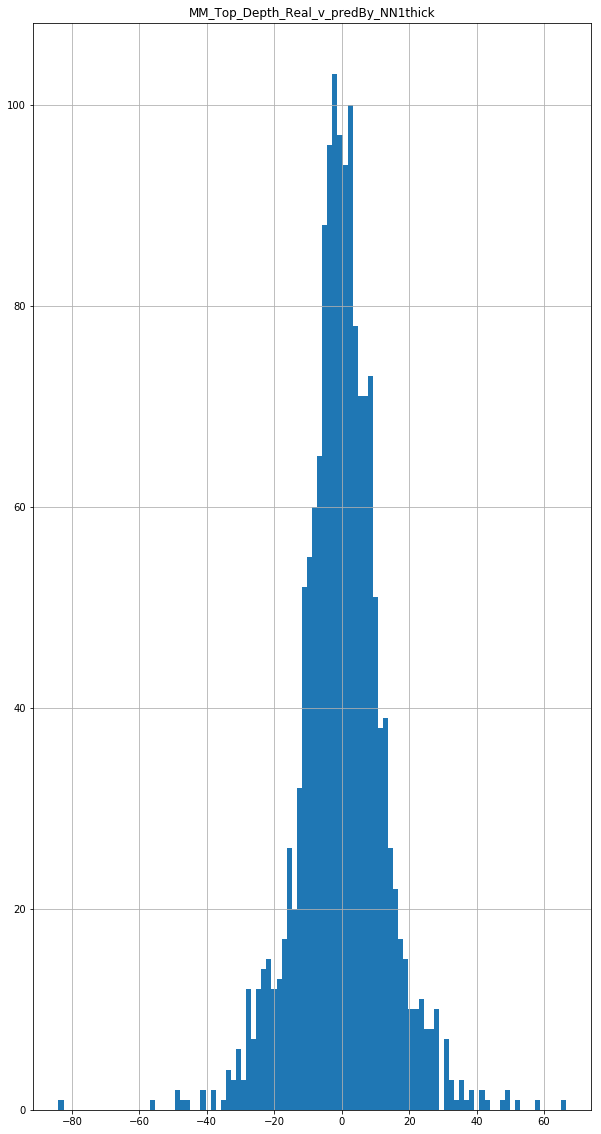

In [151]:
### Positive numbers are where real top is greater than predicted (200 vs. 100)
### Negative numbers are where real top is less than predicted top (0 vs. 500)
### Many negative numbers might be due to :
###    1) zeros & blanks being skipped in nearest neighbors and
###    2) not being skipped in 'real' tops 
doNotSaveThisDF_temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(10,20))

## The really high negative values might be from wells that don't have a base pick ? 0 - thickness in neighboring well where as the high positive numbers might be wells that have a base in neighboring well but not in well being predicting for?

### Let's investigate further by looking at the distribution of the thickness in nieghboring wells

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7aa3e9dac198>]],
      dtype=object)

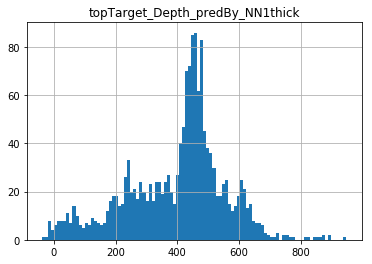

In [152]:
#MM_Top_Depth_Real_v_predBy_NN1thick
# temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100)
doNotSaveThisDF_temp5.hist(column='topTarget_Depth_predBy_NN1thick', bins=100)

- Most are around 430 with a big range that has shoulders around 200 and 600 thickness. 
- There are a few with less than zero? Are thosse were there was a base but not a top or the other way?

#### Let's check to see how many McMurray_Top_DEPTH and McMurray_Base_DEPTH are zeros

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7aa3e9cb3c50>]],
      dtype=object)

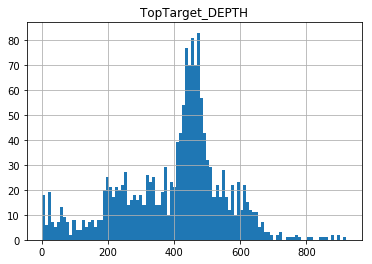

In [153]:
doNotSaveThisDF_temp5.hist(column='TopTarget_DEPTH', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7aa3e9bc5c18>]],
      dtype=object)

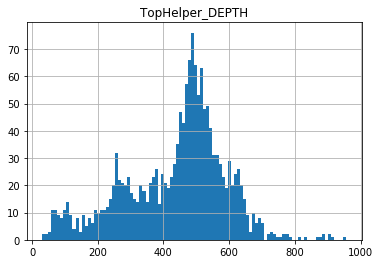

In [154]:
doNotSaveThisDF_temp5.hist(column='TopHelper_DEPTH', bins=100)

### Let's investigate what is causing the problem above and find out where the zeros or missing values are

First, get absolute numbers intead of just a histogram

In [155]:
df_test = doNotSaveThisDF_temp5.copy()

In [156]:
#### number of rows in each column with null values
df_test.isnull().sum()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

In [157]:
#### number of rows in each column with zero values
df_test[df_test.NN1_topTarget_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

#### Looks like both are issue but Top is bigger issue.

In [158]:
df_test[df_test.TopHelper_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

### It appears there are 247 base McMurray picks with zero values and this is causing the problems
### Without a base, we can't add the nearest neighbor McMurray thickness to it and git a starting point to look for the top McMurray pick

### Below we will limit the dataset distribution to  only those wells that do have an interpreted McMurray base pick.

In [167]:
# no_zeros_df = df_test[(df_test['McMurray_Base_DEPTH']!=0) & (df_test['McMurray_Top_DEPTH']!=0)]
# no_zeros_df.hist(column='McMurray_Top_DEPTH', bins=100)

In [168]:
no_zeros_df =df_test.copy()

In [171]:
no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'][0:5]

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

In [172]:
##no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'] =  no_zeros_df['McMurray_Top_DEPTH'] - no_zeros_df['MM_Top_Depth_predBy_NN1thick'] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7aa3e99ff2e8>]],
      dtype=object)

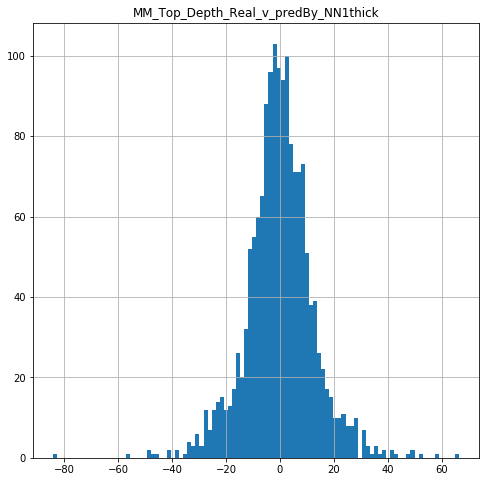

In [173]:
no_zeros_df.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(8,8))

In [174]:
len(no_zeros_df)

1601

### The histogram above seems more reasonable

Let's take out the column that might leak information about a wells top McMurray depth and then save this dataframe.

In [175]:
no_zeros_df_TopDepthVsNNleak = no_zeros_df.drop('MM_Top_Depth_Real_v_predBy_NN1thick', 1)

In [176]:
no_zeros_df_TopDepthVsNNleak

SitID        lat         lng                  UWI  TopHelper_HorID  \
0     102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1     102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2     102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3     102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4     102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   
5     102503  54.771449 -110.402983  00/11-04-067-03W4/0            14000   
6     102505  54.785901 -110.422131  00/10-08-067-03W4/0            14000   
7     102507  54.800533 -110.345762  00/10-14-067-03W4/0            14000   
8     102514  54.829633 -110.396621  00/10-28-067-03W4/0            14000   
9     102517  54.840441 -110.320301  00/07-36-067-03W4/0            14000   
10    102518  54.771451 -110.498414  00/10-02-067-04W4/0            14000   
11    102565  54.785896 -110.599928  00/10-07-067-04W4/0            14000   
12    102577  54.814989 -110.479147  00/11-24-067-04W4/0            14000   
13    102581  54.840482 -110.549109  00/07-33-067-04W4/0            14000   
14    102583  54.775090 -110.688675  00/13-03-067-05W4/0            14000   
15    102589  54.796954 -110.707896  00/06-16-067-05W4/0            14000   
16    102592  54.826012 -110.625318  00/07-25-067-05W4/0            14000   
17    102596  54.844116 -110.701599  00/10-33-067-05W4/0            14000   
18    102597  54.775087 -110.777910  00/15-01-067-06W4/0            14000   
19    102606  54.796947 -110.885862  00/06-17-067-06W4/0            14000   
20    141727  54.811402 -110.803309  00/07-23-067-06W4/0            14000   
21    102609  54.822471 -110.879581  00/02-29-067-06W4/0            14000   
22    102610  54.771468 -111.038407  00/11-05-067-07W4/0            14000   
23    102611  54.796937 -110.936727  00/06-13-067-07W4/0            14000   
24    102614  54.822460 -110.936727  00/03-25-067-07W4/0            14000   
25    102615  54.826041 -111.025865  00/08-29-067-07W4/0            14000   
26    102619  54.771478 -111.133860  00/10-03-067-08W4/0            14000   
27    102620  54.796927 -111.089256  00/06-13-067-08W4/0            14000   
28    141732  54.829658 -111.184726  00/10-29-067-08W4/0            14000   
29    102626  54.840503 -111.133864  00/07-34-067-08W4/0            14000   
30    163611  54.826009 -111.445246  00/06-27-067-10W4/0            14000   
31    163612  54.844056 -111.508948  00/09-31-067-10W4/0            14000   
32    102630  54.764109 -111.674106  00/03-06-067-11W4/0            14000   
33    163614  54.844075 -111.616965  00/10-33-067-11W4/0            14000   
34    141733  54.767736 -111.718675  00/07-02-067-12W4/0            14000   
35    102633  54.767676 -111.788610  00/08-05-067-12W4/0            14000   
36    102640  54.796863 -111.699581  00/06-13-067-12W4/0            14000   
37    141734  54.811292 -111.737853  00/08-22-067-12W4/2            14000   
38    102656  54.771211 -111.902778  00/11-03-067-13W4/0            14000   
39    102666  54.843896 -111.896572  00/10-34-067-13W4/0            14000   
40    102671  54.843897 -111.852009  00/11-36-067-13W4/0            14000   
41    102672  54.767516 -112.055371  00/06-03-067-14W4/0            14000   
42    102679  54.785519 -112.112394  00/12-08-067-14W4/0            14000   
43    102681  54.785555 -112.055334  00/11-10-067-14W4/0            14000   
44    102684  54.803748 -112.137831  00/13-18-067-14W4/0            14000   
45    102686  54.767425 -112.169807  00/08-02-067-15W4/0            14000   
46    141736  54.770993 -112.277768  00/10-06-067-15W4/0            14000   
47    102698  54.814564 -112.207734  00/11-22-067-15W4/0            14000   
48    102702  54.839992 -112.284017  00/06-31-067-15W4/0            14000   
49    102710  54.782042 -112.430364  00/07-07-067-16W4/0            14000   
50    102714  54.785454 -112.309435  00/11-12-067-16W4/0            14000   
51 

In [177]:
#### dumping wells dataframe that has no zeros in NN depth to pickle file
pickle.dump(no_zeros_df_TopDepthVsNNleak, open( "wells_df__NB_KDtreePost20180927_vA__NoMcTopLeak_v3.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

### Let's look at the results on a map

In [178]:
import os
import folium
print(folium.__version__)
import branca.colormap as cm
import os
import math
env = %env
pd.set_option('display.max_rows', 2000)

0.5.0


In [179]:
linear2 = cm.LinearColormap(
    ['#edf8b1','#7fcdbb','#2c7fb8','#273891'],
    vmin=-100, vmax=75
)

linear2


# linear3 = cm.LinearColormap(
#     ['darkblue','blue','lightblue','lightgreen','green','darkgreen'],
#      vmax=75,vmin=-100,
# )

# linear3

In [180]:
def depth_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 50:
            color = '#3182bd'
        elif depth > 10 and depth < 50:
            color = '#9ecae1'
        elif depth > -10 and depth < 10:
            color = 'green'
        elif depth > -50 and depth < -10:
            color = '#ffeda0'
        elif depth > -150 and depth < -50:
            color = '#feb24c'
        elif depth > -300 and depth < -150:
            color = '#f03b20'
        else:
            color = 'blue'
    return color

In [181]:
def depth_color3(depth,colorMap):
    if(math.isnan(depth)):
        print("!!!!!!!!!!!!!!!!!!!!  ' '  or nan is in depth => ", depth)
        color = '#000000'
    else:
        depth = float(depth)
        print("depth in colormap 3",depth)
        color = colorMap(depth)
        
    print("color = ",color)    
    return color

In [182]:
center2 = [54.840471, -110.269399]
zoom2 = 6
m5 = folium.Map(center2, tiles='Stamen Toner', zoom_start=zoom2)

In [189]:


list_df_for_map = no_zeros_df.values.tolist()

for row in list_df_for_map[0:]:
    print("location = ",row[1:3]," and depth is",row[12:13][0], " and UWI is ",row[3:4][0])
    folium.CircleMarker(
    location=row[1:3],
    radius=2,
    color=depth_color(row[13:14][0]),
    fill=True,
#     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
#     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
    ).add_to(m5)


# for row in list_df_for_map[0:]:
#     print("location = ",row[7:9]," and depth is",row[15:16][0], " and UWI is ",row[9:10][0])
#     folium.CircleMarker(
#     location=row[7:9],
#     radius=2,
#     color=depth_color(row[15:16][0]),
#     fill=True,
# #     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
# #     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
#     ).add_to(m5)

location =  [54.785906999999995, -110.12931999999999]  and depth is 630.0  and UWI is  00/12-08-067-01W4/0
location =  [54.782284, -110.269446]  and depth is 613.0  and UWI is  00/07-08-067-02W4/0
location =  [54.785892000000004, -110.186851]  and depth is 613.0  and UWI is  00/09-11-067-02W4/0
location =  [54.829624, -110.26942199999999]  and depth is 613.0  and UWI is  00/10-29-067-02W4/0
location =  [54.840470999999994, -110.224832]  and depth is 603.0  and UWI is  00/06-34-067-02W4/0
location =  [54.771449, -110.402983]  and depth is 558.0  and UWI is  00/11-04-067-03W4/0
location =  [54.785901, -110.42213100000001]  and depth is 558.0  and UWI is  00/10-08-067-03W4/0
location =  [54.800532999999994, -110.34576200000001]  and depth is 558.0  and UWI is  00/10-14-067-03W4/0
location =  [54.829632999999994, -110.396621]  and depth is 572.5  and UWI is  00/10-28-067-03W4/0
location =  [54.840441000000006, -110.320301]  and depth is 606.5  and UWI is  00/07-36-067-03W4/0
location =  [5

location =  [55.015042, -110.784125]  and depth is 582.0  and UWI is  00/06-36-069-06W4/0
location =  [54.97150500000001, -111.000449]  and depth is 519.0  and UWI is  00/08-16-069-07W4/0
location =  [55.004192, -111.07006299999999]  and depth is 515.0  and UWI is  00/12-30-069-07W4/0
location =  [54.956865, -111.10216299999999]  and depth is 533.0  and UWI is  00/08-11-069-08W4/0
location =  [55.004212, -111.171774]  and depth is 548.0  and UWI is  00/12-28-069-08W4/0
location =  [55.018648, -111.222626]  and depth is 515.0  and UWI is  00/12-31-069-08W4/0
location =  [54.942377, -111.362705]  and depth is 690.07  and UWI is  00/07-06-069-09W4/0
location =  [54.960469999999994, -111.305576]  and depth is 730.0  and UWI is  00/09-09-069-09W4/0
location =  [54.989561, -111.311853]  and depth is 540.5  and UWI is  00/10-21-069-09W4/0
location =  [55.00056, -111.368976]  and depth is 690.07  and UWI is  00/06-30-069-09W4/0
location =  [54.960441, -111.38813200000001]  and depth is 659.0  

location =  [55.058620999999995, -112.786325]  and depth is 511.45  and UWI is  00/07-14-070-19W4/0
location =  [55.033087, -113.548895]  and depth is 604.72  and UWI is  00/10-02-070-24W4/0
location =  [55.076674, -113.58058100000001]  and depth is 628.5  and UWI is  00/11-22-070-24W4/0
location =  [55.102148, -113.605924]  and depth is 638.56  and UWI is  00/06-33-070-24W4/0
location =  [55.033085, -113.713816]  and depth is 643.74  and UWI is  00/12-02-070-25W4/0
location =  [55.073039, -113.73290800000001]  and depth is 643.74  and UWI is  00/06-22-070-25W4/0
location =  [55.044011, -113.87946200000002]  and depth is 692.2  and UWI is  00/07-10-070-26W4/0
location =  [55.058628000000006, -113.96208200000001]  and depth is 735.79  and UWI is  00/06-18-070-26W4/0
location =  [55.076685, -113.853954]  and depth is 681.0  and UWI is  00/10-23-070-26W4/0
location =  [55.105895999999994, -113.930341]  and depth is 659.0  and UWI is  00/10-32-070-26W4/0
location =  [55.02989399999999, -11

location =  [55.146887, -114.76808799999999]  and depth is 957.07  and UWI is  00/05-18-071-05W5/0
location =  [55.284335999999996, -110.008902]  and depth is 626.5  and UWI is  00/16-36-072-01W4/0
location =  [55.280922, -110.33568799999999]  and depth is 548.0  and UWI is  00/12-36-072-03W4/0
location =  [55.204661, -110.592552]  and depth is 498.0  and UWI is  00/05-05-072-04W4/0
location =  [55.237373, -110.53486699999999]  and depth is 515.0  and UWI is  00/11-15-072-04W4/0
location =  [55.262848, -110.554227]  and depth is 494.0  and UWI is  00/07-28-072-04W4/0
location =  [55.262825, -110.61199099999999]  and depth is 505.0  and UWI is  00/06-30-072-04W4/0
location =  [55.204653, -110.63768600000002]  and depth is 493.0  and UWI is  00/06-01-072-05W4/0
location =  [55.208263, -110.766117]  and depth is 549.5  and UWI is  00/11-06-072-05W4/0
location =  [55.233757, -110.702059]  and depth is 532.0  and UWI is  00/08-16-072-05W4/0
location =  [55.266454, -110.66963500000001]  and 

location =  [55.368202000000004, -111.554667]  and depth is 512.5  and UWI is  00/10-36-073-11W4/0
location =  [55.306425, -111.759795]  and depth is 504.0  and UWI is  00/07-10-073-12W4/0
location =  [55.30641899999999, -111.73415700000001]  and depth is 540.5  and UWI is  00/07-11-073-12W4/0
location =  [55.368196999999995, -111.84304099999999]  and depth is 525.0  and UWI is  00/11-31-073-12W4/0
location =  [55.295581000000006, -111.945595]  and depth is 524.0  and UWI is  00/11-04-073-13W4/0
location =  [55.342739, -111.926207]  and depth is 520.0  and UWI is  00/13-22-073-13W4/0
location =  [55.35374, -111.996872]  and depth is 575.0  and UWI is  00/11-30-073-13W4/0
location =  [55.364582999999996, -111.862349]  and depth is 525.0  and UWI is  00/07-36-073-13W4/0
location =  [55.291947, -112.15071100000002]  and depth is 470.0  and UWI is  00/06-06-073-14W4/0
location =  [55.30641899999999, -112.09943]  and depth is 474.27  and UWI is  00/06-09-073-14W4/0
location =  [55.335504, -

location =  [55.422762, -112.50968700000001]  and depth is 427.63  and UWI is  00/06-23-074-17W4/0
location =  [55.437388, -112.484048]  and depth is 522.73  and UWI is  00/06-25-074-17W4/0
location =  [55.451826000000004, -112.734174]  and depth is 451.1  and UWI is  00/07-32-074-18W4/0
location =  [55.37916, -112.91991399999999]  and depth is 579.12  and UWI is  00/06-06-074-19W4/0
location =  [55.451778000000004, -112.91993899999999]  and depth is 566.0  and UWI is  00/06-31-074-19W4/0
location =  [55.397266, -113.201939]  and depth is 568.0  and UWI is  00/11-08-074-21W4/0
location =  [55.411908999999994, -113.17629199999999]  and depth is 568.0  and UWI is  00/11-16-074-21W4/0
location =  [55.451831999999996, -113.11866599999999]  and depth is 582.47  and UWI is  00/07-35-074-21W4/0
location =  [55.400863, -113.34948100000001]  and depth is 671.0  and UWI is  00/15-08-074-22W4/0
location =  [55.397257999999994, -113.30452199999999]  and depth is 553.0  and UWI is  00/11-10-074-22W

location =  [55.586366000000005, -110.97288999999999]  and depth is 369.0  and UWI is  AA/10-14-076-07W4/0
location =  [55.59719499999999, -110.94700800000001]  and depth is 409.0  and UWI is  00/07-24-076-07W4/0
location =  [55.571732999999995, -111.205802]  and depth is 421.23  and UWI is  00/10-08-076-08W4/0
location =  [55.571735, -111.128198]  and depth is 461.0  and UWI is  00/10-11-076-08W4/0
location =  [55.600823, -111.128192]  and depth is 376.0  and UWI is  00/10-23-076-08W4/0
location =  [55.629906000000005, -111.20582900000001]  and depth is 376.0  and UWI is  00/10-32-076-08W4/0
location =  [55.597188, -111.361139]  and depth is 433.0  and UWI is  00/07-20-076-09W4/0
location =  [55.597198, -111.335255]  and depth is 459.03  and UWI is  00/07-21-076-09W4/0
location =  [55.615449, -111.283482]  and depth is 492.0  and UWI is  00/10-26-076-09W4/0
location =  [55.560885, -111.496858]  and depth is 454.5  and UWI is  00/14-04-076-10W4/0
location =  [55.586346, -111.4255929999

location =  [55.659026000000004, -112.37021399999999]  and depth is 494.0  and UWI is  00/10-11-077-16W4/0
location =  [55.684495999999996, -112.47363500000002]  and depth is 562.0  and UWI is  00/07-19-077-16W4/0
location =  [55.684487, -112.350727]  and depth is 555.0  and UWI is  00/06-24-077-16W4/0
location =  [55.702749, -112.376599]  and depth is 555.0  and UWI is  00/11-26-077-16W4/0
location =  [55.71719399999999, -112.58359499999999]  and depth is 571.5  and UWI is  00/11-33-077-17W4/0
location =  [55.702688, -113.043002]  and depth is 394.41  and UWI is  00/10-28-077-20W4/0
location =  [55.644493999999995, -113.17875500000001]  and depth is 586.0  and UWI is  00/11-03-077-21W4/0
location =  [55.658931, -113.250003]  and depth is 647.4  and UWI is  00/10-07-077-21W4/0
location =  [55.640879000000005, -113.33401]  and depth is 596.8  and UWI is  00/06-03-077-22W4/0
location =  [55.68441899999999, -113.359889]  and depth is 527.91  and UWI is  00/06-21-077-22W4/0
location =  [55

location =  [55.887995, -110.902819]  and depth is 356.0  and UWI is  00/07-32-079-06W4/0
location =  [55.818993000000006, -111.013691]  and depth is 336.0  and UWI is  00/11-03-079-07W4/0
location =  [55.833431000000004, -110.98113899999998]  and depth is 340.0  and UWI is  00/10-11-079-07W4/0
location =  [55.877148999999996, -110.95501999999999]  and depth is 376.0  and UWI is  00/10-25-079-07W4/0
location =  [55.891620999999994, -111.039749]  and depth is 411.5  and UWI is  00/11-33-079-07W4/0
location =  [55.833482, -111.21598600000002]  and depth is 448.0  and UWI is  AA/10-08-079-08W4/0
location =  [55.833429, -111.111624]  and depth is 328.0  and UWI is  00/10-12-079-08W4/0
location =  [55.848117, -111.150508]  and depth is 342.5  and UWI is  00/12-14-079-08W4/0
location =  [55.877199, -111.13769599999999]  and depth is 403.5  and UWI is  AA/10-26-079-08W4/0
location =  [55.815430000000006, -111.326838]  and depth is 416.36  and UWI is  00/06-03-079-09W4/0
location =  [55.829862

location =  [55.931739, -111.776972]  and depth is 487.0  and UWI is  00/05-14-080-12W4/0
location =  [55.960823, -111.76416200000001]  and depth is 495.0  and UWI is  00/07-26-080-12W4/0
location =  [55.902638, -111.91432900000001]  and depth is 497.0  and UWI is  00/08-02-080-13W4/0
location =  [55.913486999999996, -111.96653700000002]  and depth is 500.0  and UWI is  00/01-09-080-13W4/0
location =  [55.946175, -112.011896]  and depth is 497.0  and UWI is  00/05-20-080-13W4/0
location =  [55.95724499999999, -111.999086]  and depth is 465.0  and UWI is  00/02-29-080-13W4/0
location =  [55.906251, -112.103489]  and depth is 512.0  and UWI is  00/10-03-080-14W4/0
location =  [55.931723, -112.10348799999998]  and depth is 472.0  and UWI is  00/07-15-080-14W4/0
location =  [55.949783999999994, -112.155694]  and depth is 382.0  and UWI is  00/10-20-080-14W4/0
location =  [55.964418, -112.077389]  and depth is 488.5  and UWI is  AA/10-26-080-14W4/0
location =  [55.957240000000006, -112.0970

location =  [56.011539, -113.212597]  and depth is 440.13  and UWI is  00/13-10-081-21W4/0
location =  [56.033398, -113.225889]  and depth is 440.13  and UWI is  00/07-21-081-21W4/0
location =  [56.062484, -113.206231]  and depth is 429.0  and UWI is  00/06-34-081-21W4/0
location =  [55.99345400000001, -113.33673799999998]  and depth is 451.0  and UWI is  AA/11-02-081-22W4/0
location =  [56.004291, -113.415047]  and depth is 437.5  and UWI is  00/06-08-081-22W4/0
location =  [56.033377, -113.408601]  and depth is 454.0  and UWI is  00/07-20-081-22W4/0
location =  [56.033376000000004, -113.330294]  and depth is 429.5  and UWI is  00/07-23-081-22W4/0
location =  [55.989833999999995, -113.473619]  and depth is 444.0  and UWI is  00/05-01-081-23W4/0
location =  [56.000676, -113.473623]  and depth is 454.0  and UWI is  00/04-12-081-23W4/0
location =  [56.01893199999999, -113.51301799999999]  and depth is 454.0  and UWI is  00/07-15-081-23W4/0
location =  [56.03337, -113.467257]  and depth i

location =  [56.164528000000004, -110.825709]  and depth is 294.5  and UWI is  00/08-02-083-06W4/0
location =  [56.215286, -110.93751200000001]  and depth is 362.0  and UWI is  00/15-19-083-06W4/0
location =  [56.219075, -110.950543]  and depth is 410.5  and UWI is  00/04-30-083-06W4/0
location =  [56.240788, -110.83226]  and depth is 256.5  and UWI is  00/10-35-083-06W4/0
location =  [56.171816, -111.01009499999999]  and depth is 410.5  and UWI is  00/16-03-083-07W4/0
location =  [56.193676, -111.04299099999999]  and depth is 392.5  and UWI is  00/07-16-083-07W4/0
location =  [56.211735, -110.990255]  and depth is 451.0  and UWI is  00/10-23-083-07W4/0
location =  [56.237213, -111.042992]  and depth is 424.4  and UWI is  00/07-33-083-07W4/0
location =  [56.179047, -111.23383999999999]  and depth is 505.36  and UWI is  AA/06-08-083-08W4/0
location =  [56.182663, -111.154843]  and depth is 504.0  and UWI is  00/11-11-083-08W4/0
location =  [56.211752000000004, -111.174674]  and depth is

location =  [56.531575, -112.43426699999999]  and depth is 230.5  and UWI is  AA/10-11-087-16W4/0
location =  [56.575316, -112.43426200000002]  and depth is 252.0  and UWI is  AA/10-26-087-16W4/0
location =  [56.54982, -112.613836]  and depth is 261.5  and UWI is  00/16-15-087-17W4/0
location =  [56.564265, -113.31826299999999]  and depth is 336.0  and UWI is  00/14-20-087-21W4/0
location =  [56.52796, -113.39801899999999]  and depth is 353.57  and UWI is  00/06-11-087-22W4/0
location =  [56.531562, -113.37143400000001]  and depth is 340.77  and UWI is  00/11-12-087-22W4/0
location =  [56.571678000000006, -113.45119]  and depth is 353.57  and UWI is  00/06-28-087-22W4/0
location =  [56.560644999999994, -113.53094499999999]  and depth is 310.29  and UWI is  00/11-24-087-23W4/0
location =  [56.513653000000005, -113.92316699999999]  and depth is 363.93  and UWI is  00/07-04-087-25W4/0
location =  [56.611734999999996, -110.39428899999999]  and depth is 288.65  and UWI is  00/03-10-088-03W4

location =  [56.880789, -112.698927]  and depth is 242.5  and UWI is  AA/10-08-091-17W4/0
location =  [56.895426, -112.651872]  and depth is 239.0  and UWI is  00/11-15-091-17W4/0
location =  [56.924487, -112.732399]  and depth is 252.5  and UWI is  00/11-30-091-17W4/0
location =  [56.866323, -112.75261499999999]  and depth is 246.0  and UWI is  00/10-01-091-18W4/0
location =  [56.891803, -112.77946899999999]  and depth is 236.0  and UWI is  00/07-14-091-18W4/0
location =  [56.924498, -112.77946999999999]  and depth is 260.0  and UWI is  00/10-26-091-18W4/0
location =  [56.935341, -112.833169]  and depth is 252.5  and UWI is  00/07-33-091-18W4/0
location =  [57.000765, -111.350559]  and depth is 92.05  and UWI is  AA/16-22-092-09W4/0
location =  [57.01900500000001, -111.41746699999999]  and depth is 88.0  and UWI is  AA/03-32-092-09W4/0
location =  [56.946364, -111.558226]  and depth is 92.0  and UWI is  AA/04-04-092-10W4/0
location =  [56.968038, -111.55154499999999]  and depth is 30.

location =  [57.215472999999996, -110.856482]  and depth is 325.0  and UWI is  AA/10-02-095-06W4/0
location =  [57.229921999999995, -110.856481]  and depth is 325.0  and UWI is  AA/10-11-095-06W4/0
location =  [57.20821, -110.98517199999999]  and depth is 301.0  and UWI is  AA/01-01-095-07W4/0
location =  [57.237367000000006, -111.025622]  and depth is 297.0  and UWI is  00/03-14-095-07W4/0
location =  [57.280846999999994, -111.012245]  and depth is 175.0  and UWI is  AA/01-35-095-07W4/0
location =  [57.27723100000001, -111.55374499999999]  and depth is 113.0  and UWI is  AB/16-28-095-10W4/0
location =  [57.226259999999996, -112.42041599999999]  and depth is 287.0  and UWI is  00/08-07-095-15W4/0
location =  [57.22264499999999, -112.46087]  and depth is 316.69  and UWI is  00/03-12-095-16W4/0
location =  [57.269968999999996, -112.46087299999999]  and depth is 300.0  and UWI is  AA/06-25-095-16W4/0
location =  [57.28441899999999, -112.46087299999999]  and depth is 300.0  and UWI is  00/

In [190]:
m5

### In general it seems the variance is relatively evenly distributed. 
A lot of the map has green, which means the neighboring wells thickness + base results in a top prediction that is within plus or minues 10 feet. Where the difference is outside that range, it seems it isn't that much farther off most of the time. There might be some areas in NE and eastern margin where variance is larger than in central area.

In [87]:
m5.save(os.path.join('.', 'MM_Top_Depth_Real_v_predBy_NN1thick_v2.html'))

## Lets now look at the distribution of the difference between target depth and depth predicted just from nearest neighbor

In [191]:
no_zeros_df_TopDepthVsNN = no_zeros_df.copy()

In [197]:
no_zeros_df_TopDepthVsNN.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  0.0  
1                            520.5                                 -5.5  
2                            480.0                                  0.0  
3                            552.5                                 -3.5  
4                            524.0                                  5.0

In [231]:
def error_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 80:
            color = 'black'
        elif depth >= 30 and depth < 60:
            color = 'orange'
        elif depth > 5 and depth < 30:
            color = 'yellow'
        elif depth >= -5 and depth <= 5:
            color = 'green'
        elif depth >= -30 and depth < -5:
            color = 'brown'
        elif depth >= -60 and depth < -30:
            color = 'purple'
        else:
            color = 'pink'
    return color

In [232]:
def makeMap(centerLatLongArray,tilesStr,zoom_startInt,radiusInt,df):
    m7 = folium.Map(centerLatLongArray, tiles=tilesStr, zoom_start=zoom_startInt)
    list_df_for_map = df.values.tolist()

    for row in list_df_for_map[0:]:
        #print("location = ",row[1:3]," and depth is",row[12:13][0], " and UWI is ",row[3:4][0])
        folium.CircleMarker(
        location=row[1:3],
        radius=radiusInt,
        color=error_color(row[15:16][0]),
        fill=True,
         #popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
         popup=folium.Popup((str(row[1:3])+ ", error in Top Target="+str(row[15:16][0])), parse_html=True)
        ).add_to(m7)
    return m7


In [233]:
m7 = makeMap([54.840471, -110.269399],'Stamen Toner',6,2,no_zeros_df_TopDepthVsNN)

In [234]:
m7

#### might try this d3.js block of leaflet.js for ideas on how to draw polygons over the map and then use those polygons as features.

https://bl.ocks.org/danswick/d30c44b081be31aea483

### Future work

In [83]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    
    
    return uwi_array, distance_array
    

In [84]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return uwi_nearest, uwi_array, nearest_TopM_depth, avg_TopM_depth, nearest_BaseM_depth, avg_BaseM_depth
    

In [85]:
#### 2. Return an array of pick depths at N neighbor wells within a certain maximum distance.
#### takes in array or pandas df? returns dataframe?
def arrayOfPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return array_of_depths
    

In [86]:
#### 3. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def avgDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return avg_of_depthsAbvBelow

In [87]:
#### 4. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def arrayDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return array_of_depthsAbvBelow

# Next step is to bring in the dataframe with the well data that has been split into train and test portions. 
# We will:
## 1. Merge it with the location, picks, and nearest neighbors data.
## 2. Get a list of the wells that are in the test dataset and re-run the nearest neighbors process using only the wells in the training dataset!
## 3. We'll then over-write the neighbor thickness feature columns but only for the rows that correspond to the training wells, not the test wells.